<a href="https://colab.research.google.com/github/cassieliang1211/Option_pricing_with_NNs_and_Traditional_Models/blob/main/SP500_option_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/gdrive/MyDrive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


''

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1. Loading Datasets

> Loading data from JSON files (which are compressed using the .bz2 format). Each file represents option data for S&P500 (the parent company of Google) for a particular year, from 2017 to 2021.


In [ ]:
df2017 = pd.read_json('/content/drive/MyDrive/project/option_data/sp500_2017.json.bz2', compression='bz2', orient='index')
df2018 = pd.read_json('/content/drive/MyDrive/project/option_data/sp500_2018.json.bz2', compression='bz2', orient='index')
df2019 = pd.read_json('/content/drive/MyDrive/project/option_data/sp500_2019.json.bz2', compression='bz2', orient='index')
df2020 = pd.read_json('/content/drive/MyDrive/project/option_data/sp500_2020.json.bz2', compression='bz2', orient='index')
df2021 = pd.read_json('/content/drive/MyDrive/project/option_data/sp500_2021.json.bz2', compression='bz2', orient='index')

**Concatenating Datasets and Creating Subsets** based on Time to Maturity

> By splitting the data, can look closely at how each type of option (short, medium, long) behaves under different situations.

In [ ]:
from sklearn.model_selection import train_test_split
full_dataset = pd.concat([df2017, df2018, df2019, df2020, df2021])

# Create subsets based on time to maturity ranges
short_term_data = full_dataset[full_dataset['time_to_maturity'] <= 30]
mid_term_data = full_dataset[(full_dataset['time_to_maturity'] > 30) & (full_dataset['time_to_maturity'] <= 365)]
long_term_data = full_dataset[full_dataset['time_to_maturity'] > 365]

**Spliting each dataset into training and testing sets**

> This code reserves 80% of the shuffled data for training and 20% for testing.



In [ ]:
# Shuffle the combined dataframe
shuffled_dataset_short = short_term_data.sample(frac=1, random_state=42)
shuffled_dataset_mid = mid_term_data.sample(frac=1, random_state=42)
shuffled_dataset_long = long_term_data.sample(frac=1, random_state=42)

# Calculate the index position for the split
split_index_short = int(0.8 * len(shuffled_dataset_short))
split_index_mid = int(0.8 * len(shuffled_dataset_mid))
split_index_long = int(0.8 * len(shuffled_dataset_long))

# Split the shuffled dataframe into train and test sets
train_data_sp500_short = shuffled_dataset_short.iloc[:split_index_short]
test_data_sp500_short = shuffled_dataset_short.iloc[split_index_short:]

train_data_sp500_mid = shuffled_dataset_mid.iloc[:split_index_mid]
test_data_sp500_mid = shuffled_dataset_mid.iloc[split_index_mid:]

train_data_sp500_long = shuffled_dataset_long.iloc[:split_index_long]
test_data_sp500_long = shuffled_dataset_long.iloc[split_index_long:]

**Remove Duplicate Rows**


> Reducing redundant data can make subsequent data processing and modeling steps more efficient, and it can avoid model overfitting.

In [ ]:
# Remove duplicated rows_train
train_data_sp500_short = train_data_sp500_short.drop_duplicates()
train_data_sp500_mid = train_data_sp500_mid.drop_duplicates()
train_data_sp500_long = train_data_sp500_long.drop_duplicates()


# Remove duplicated rows_test
test_data_sp500_short = test_data_sp500_short.drop_duplicates()
test_data_sp500_mid = test_data_sp500_mid.drop_duplicates()
test_data_sp500_long = test_data_sp500_long.drop_duplicates()

**Sort by date**


> Organized by date for clarity and potential time-oriented analyses.


In [ ]:
# sort by the "date" column
train_data_sp500_short = train_data_sp500_short.sort_values(by='date')
test_data_sp500_short = test_data_sp500_short.sort_values(by='date')
train_data_sp500_mid = train_data_sp500_mid.sort_values(by='date')
test_data_sp500_mid = test_data_sp500_mid.sort_values(by='date')
train_data_sp500_long = train_data_sp500_long.sort_values(by='date')
test_data_sp500_long = test_data_sp500_long.sort_values(by='date')


In [ ]:
# Print the number of samples in the training
print("train_data_short dataset size:", len(train_data_sp500_short))
print("test_data_short dataset size:", len(test_data_sp500_short))
print("train_data_mid dataset size:", len(train_data_sp500_mid))
print("test_data_mid dataset size:", len(test_data_sp500_mid))
print("train_data_long dataset size:", len(train_data_sp500_long))
print("test_data_long dataset size:", len(test_data_sp500_long))

train_data_short dataset size: 3694658
test_data_short dataset size: 1045509
train_data_mid dataset size: 8283054
test_data_mid dataset size: 2618223
train_data_long dataset size: 663322
test_data_long dataset size: 188927


**Visualizing the distribution of specific variables**

> The visualization can help in understanding the distribution and overlap of data between training and testing sets for each time-to-maturity category.

> The training and test sets are drawn from the same distribution, the risk of overfitting is reduced as the model won't be penalized for learning features that are consistent across both sets. Visualizing data distributions and their consistency makes results and subsequent analyses easier to interpret.

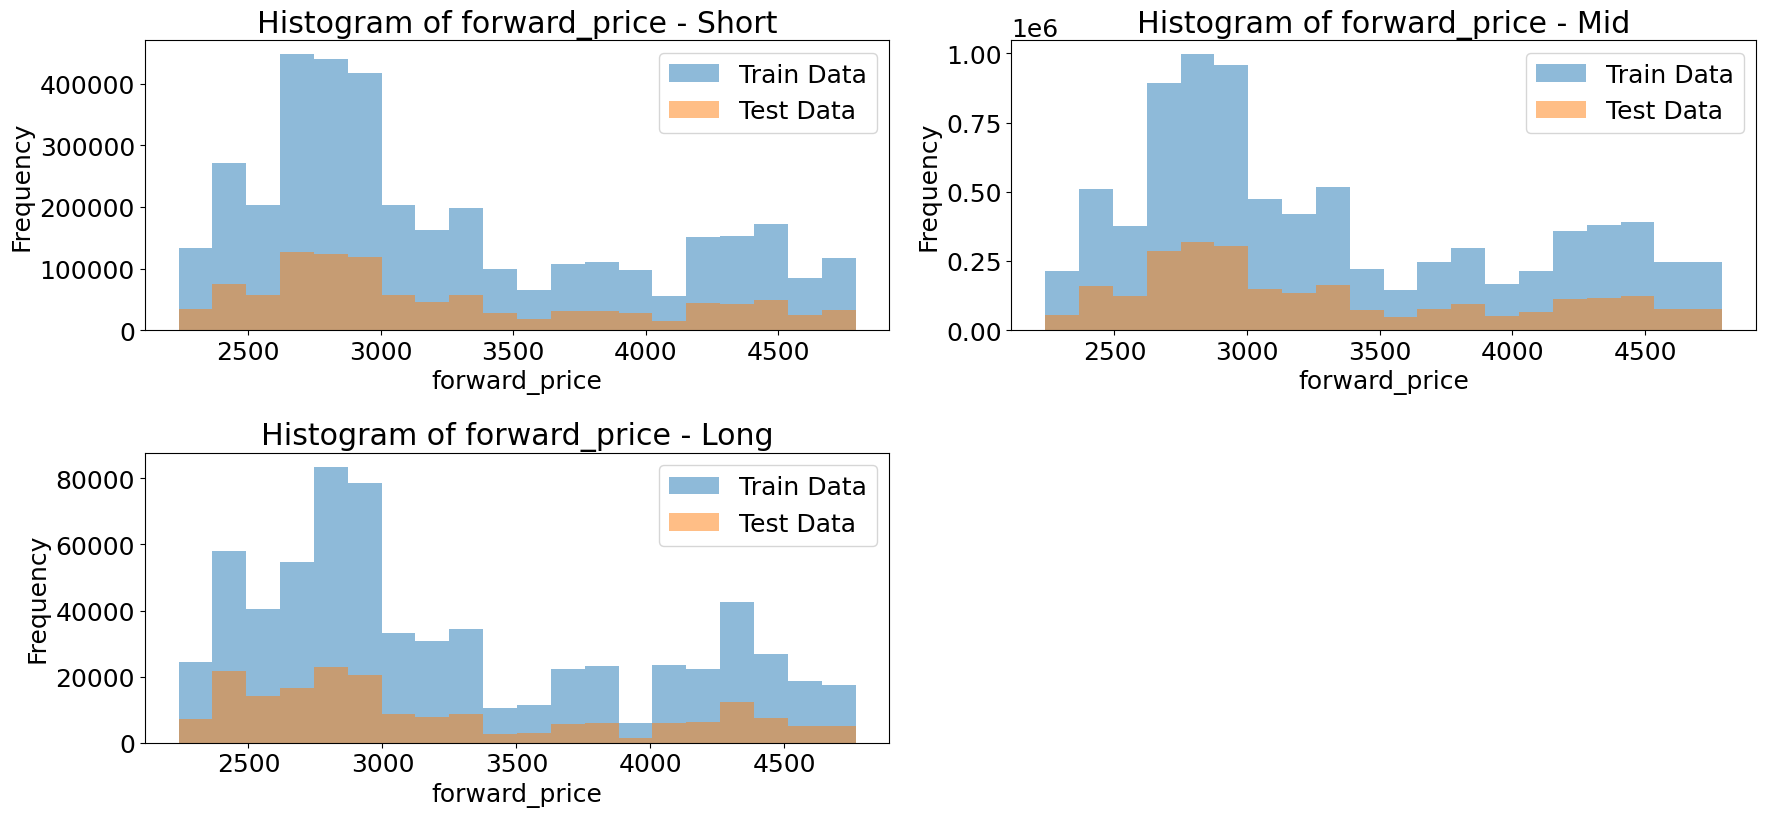

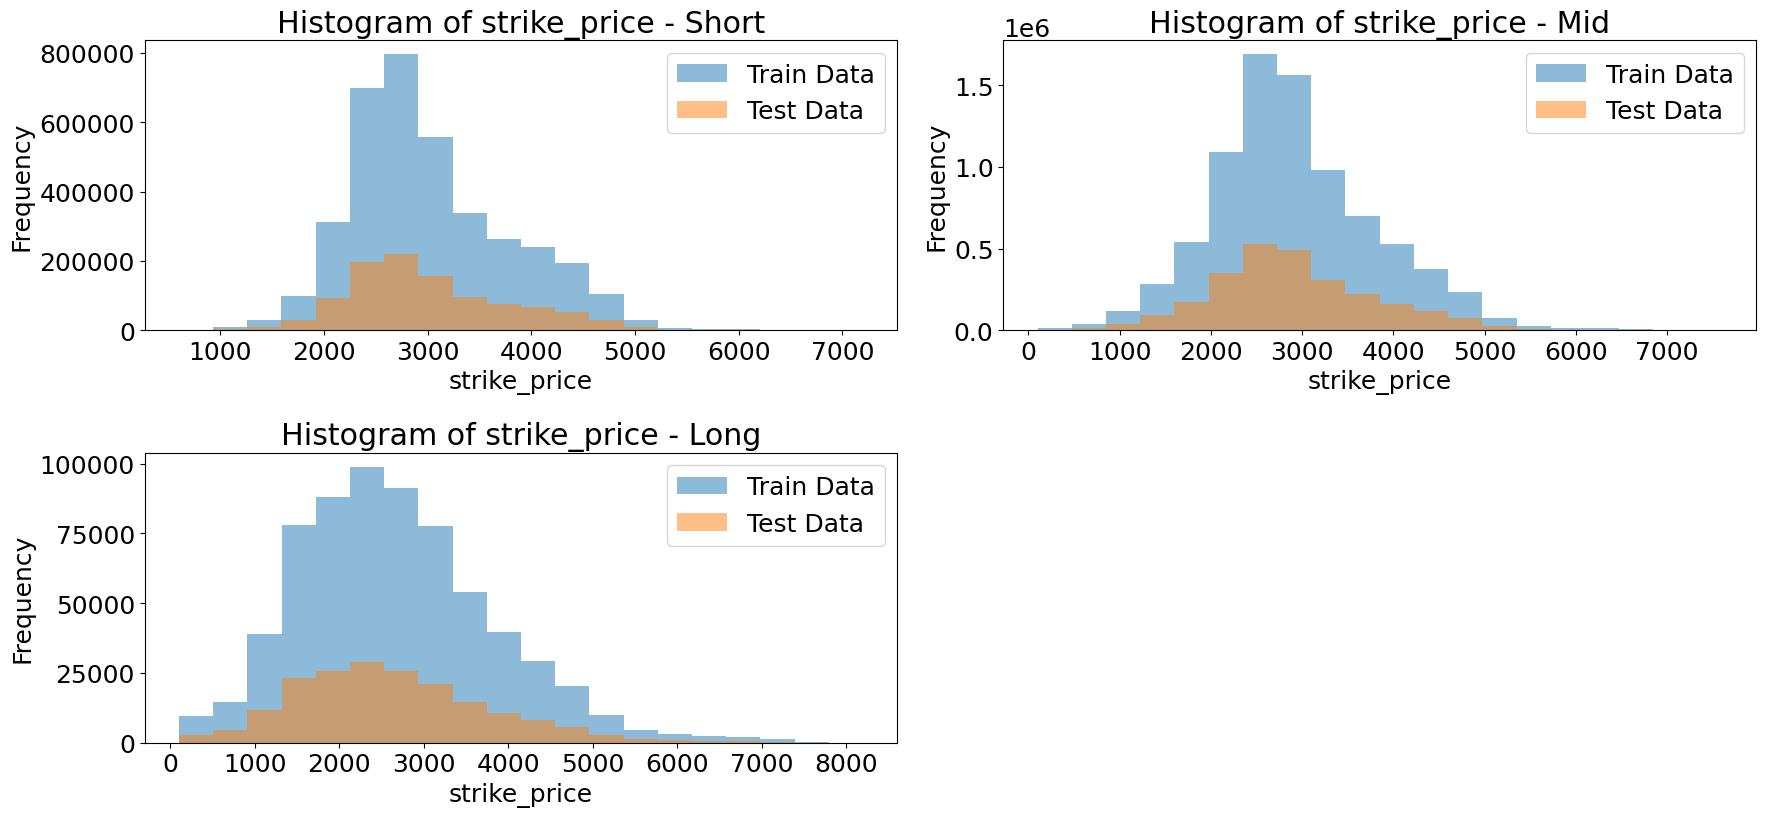

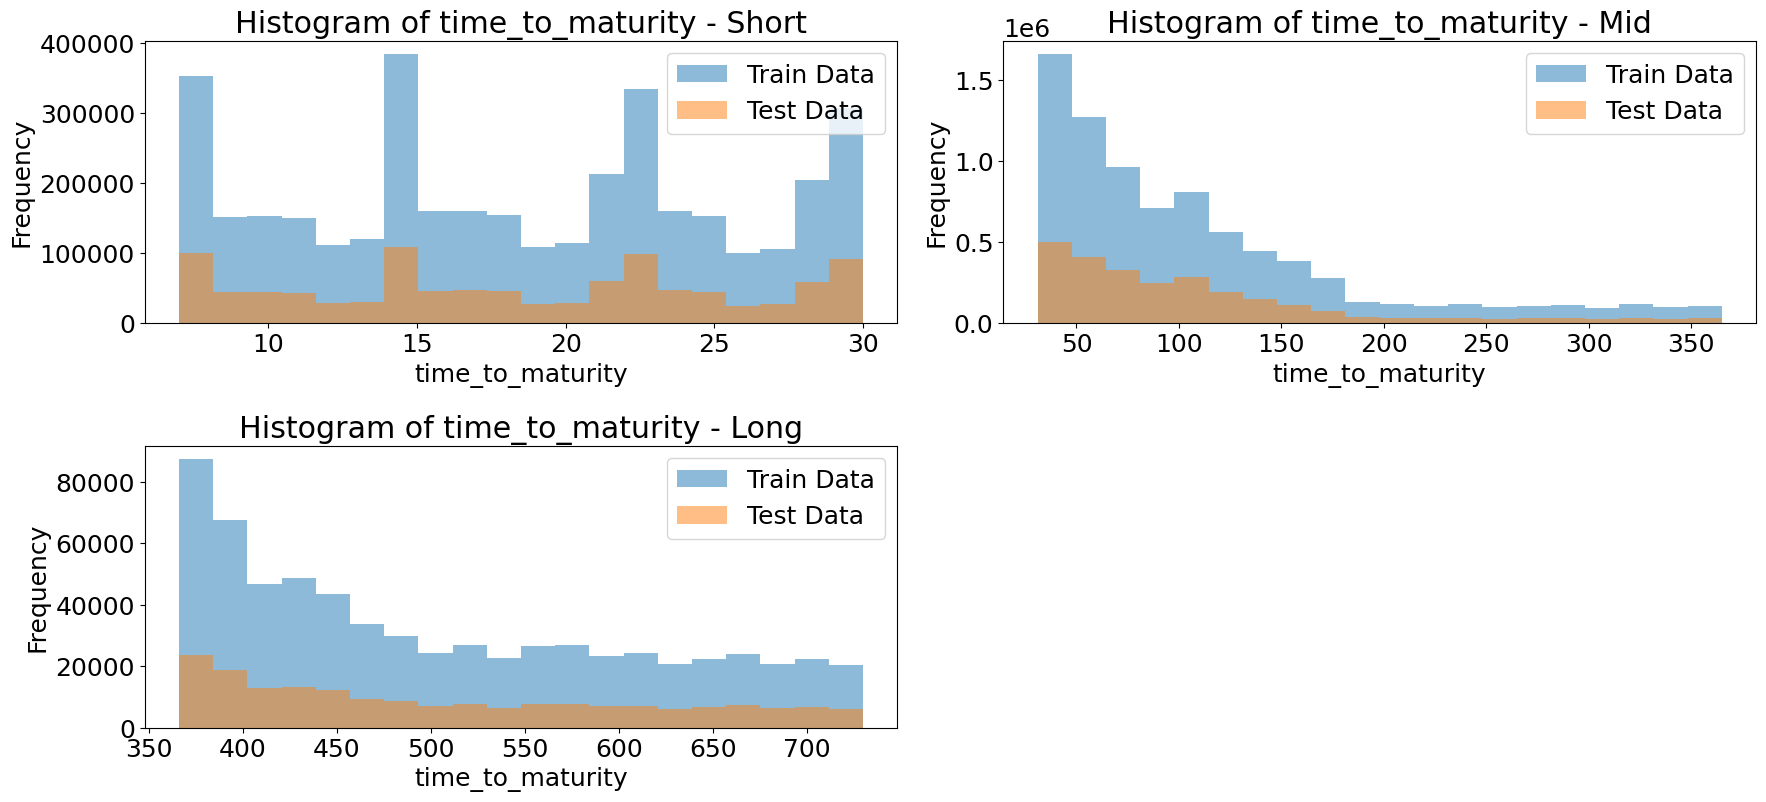

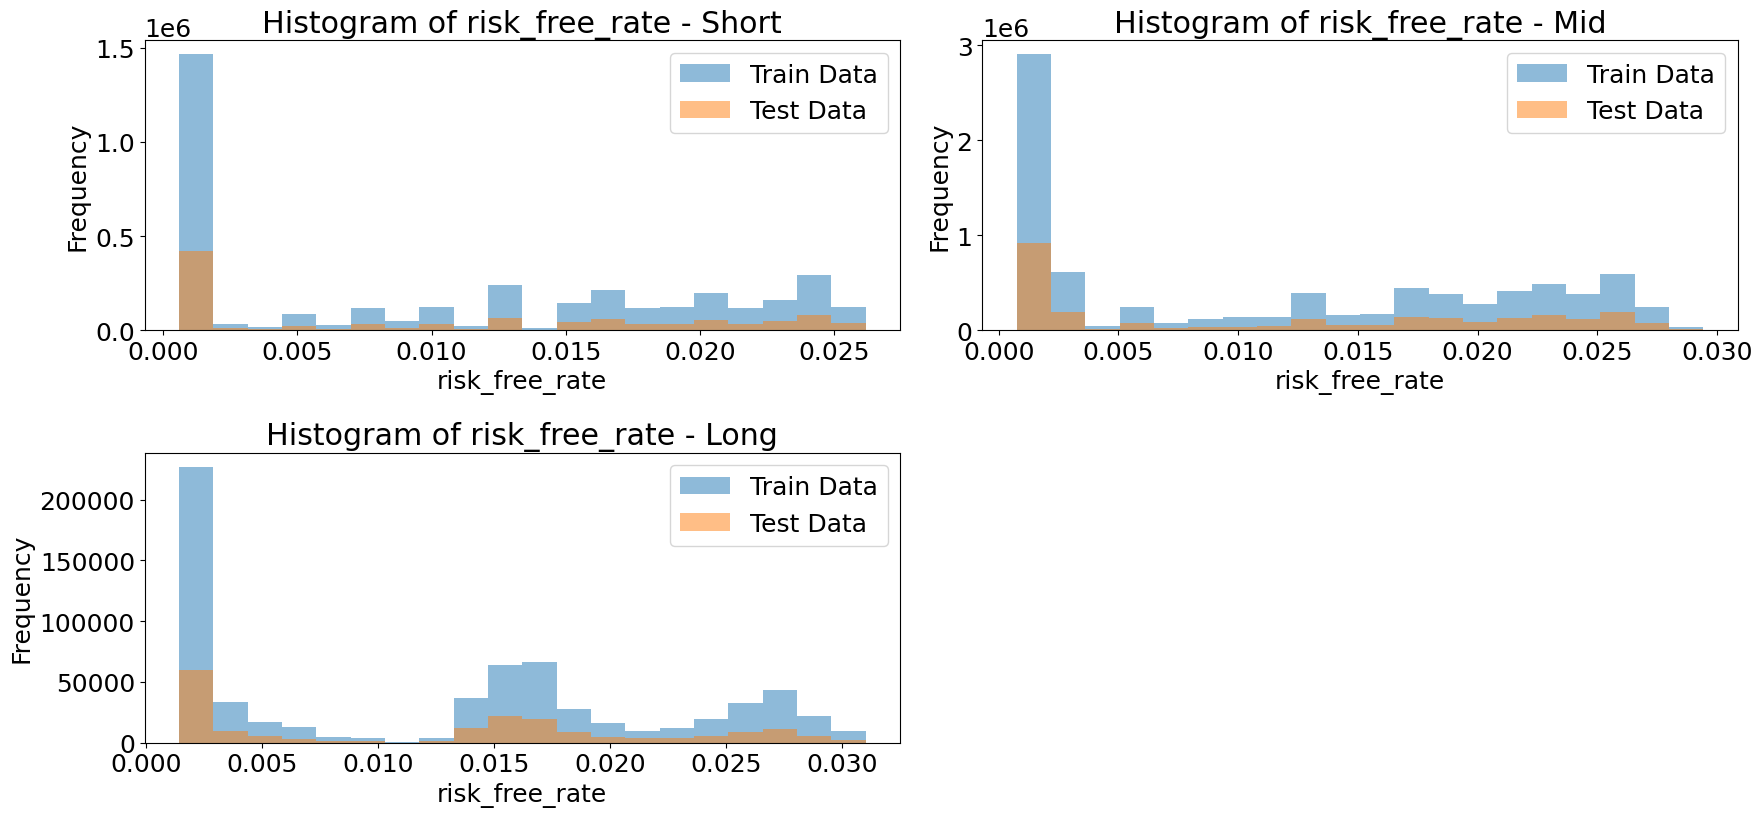

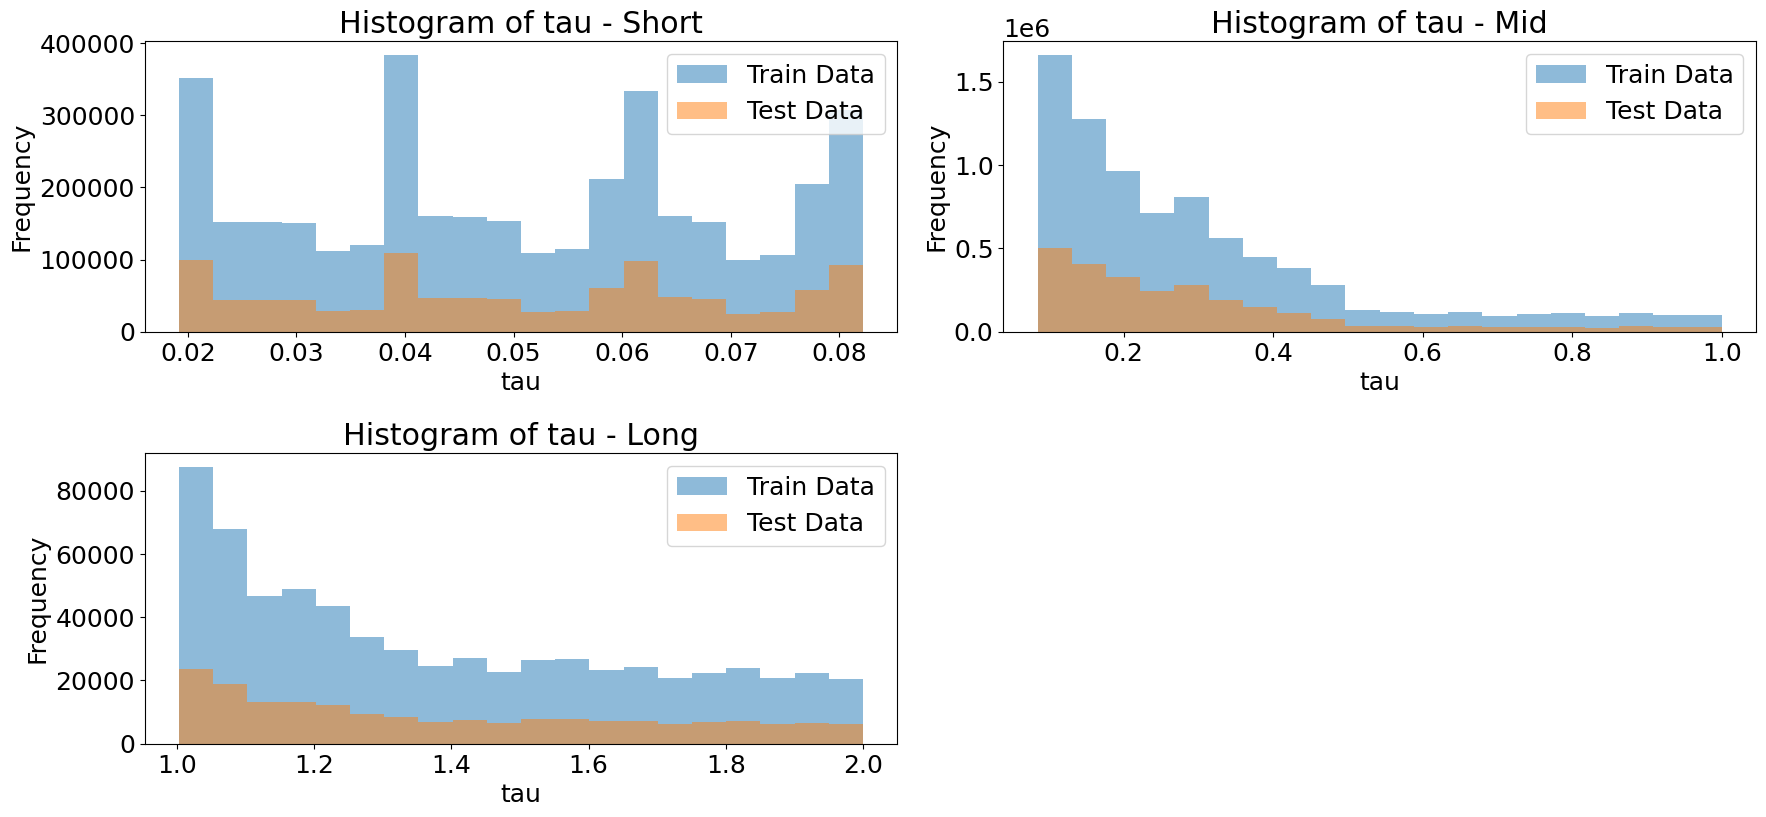

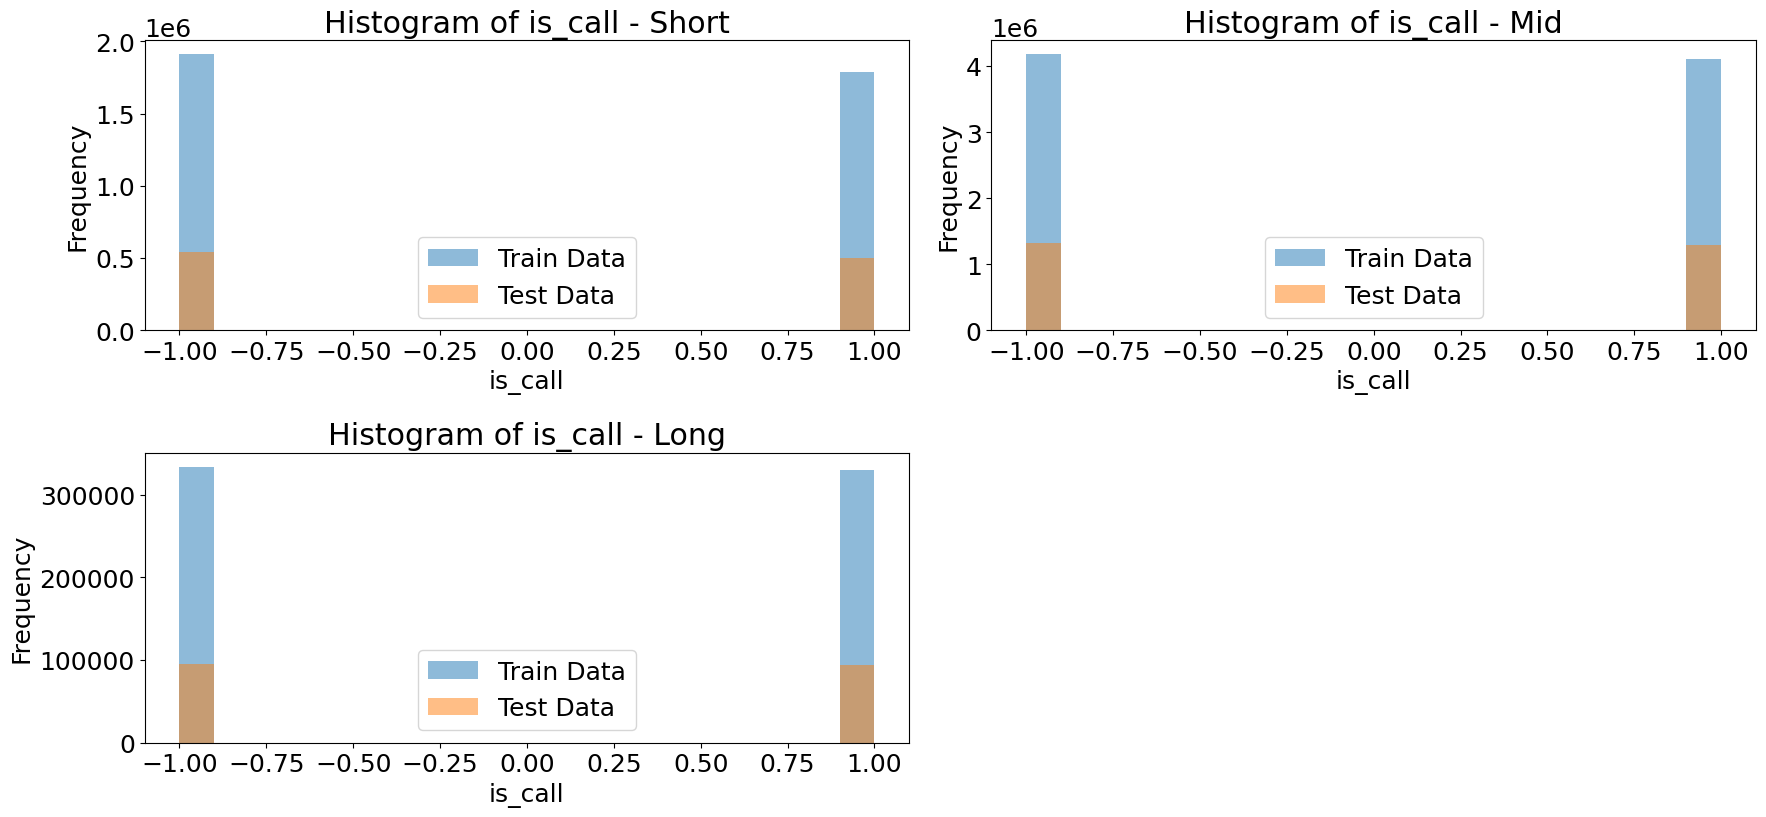

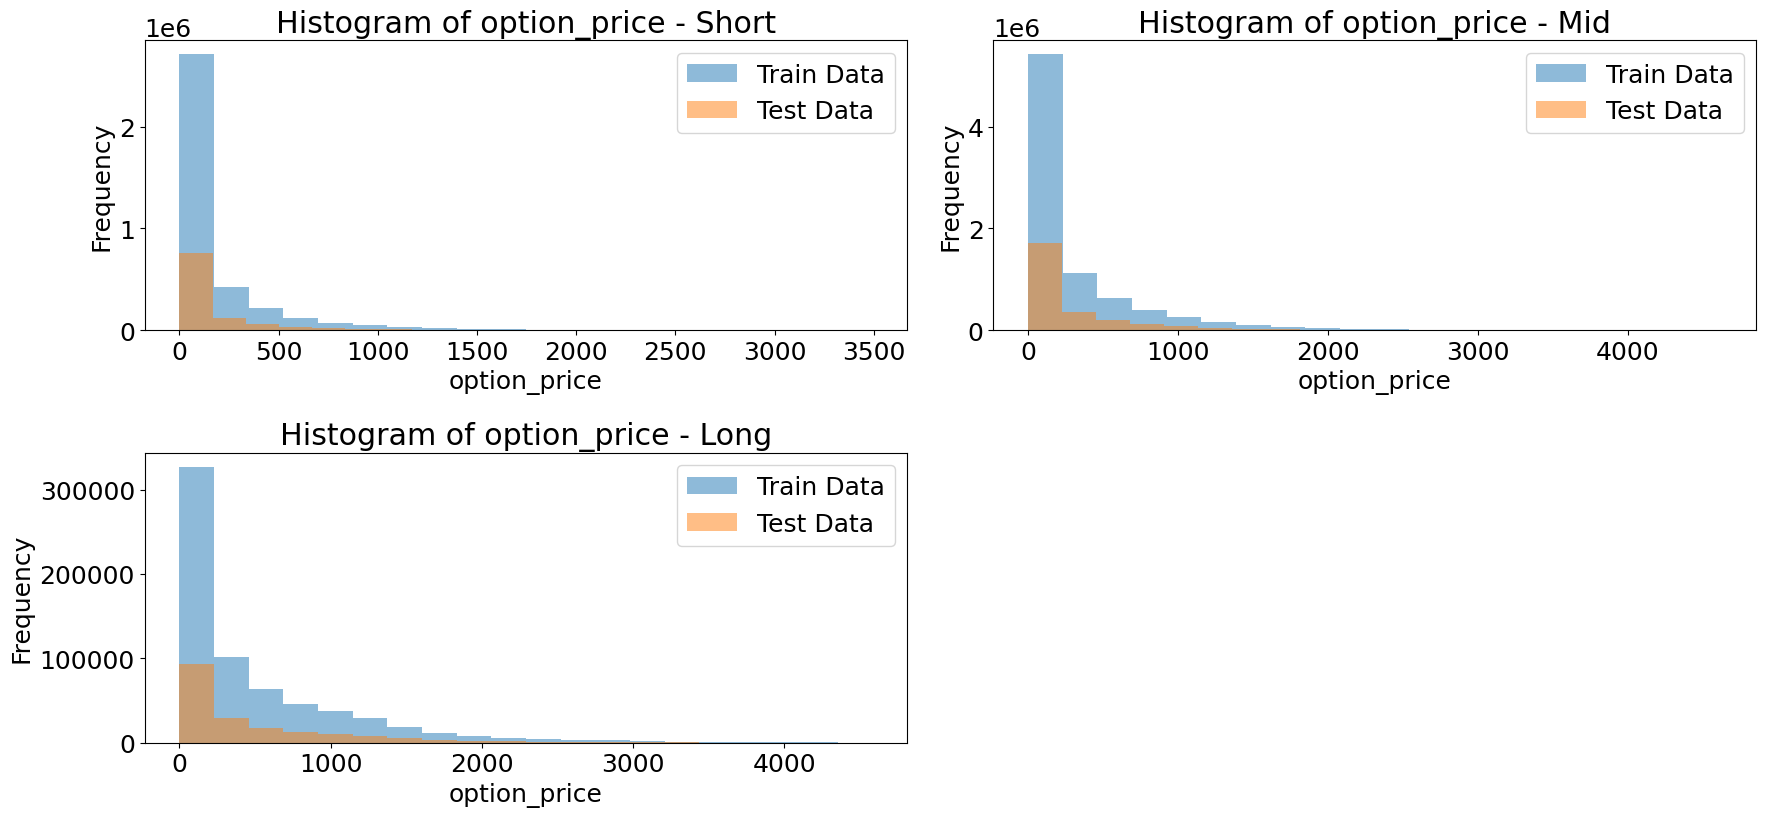

In [ ]:
import matplotlib.pyplot as plt

# Define the datasets and their corresponding names
datasets = [
    (train_data_sp500_short, test_data_sp500_short, 'Short'),
    (train_data_sp500_mid, test_data_sp500_mid, 'Mid'),
    (train_data_sp500_long, test_data_sp500_long, 'Long')
]

# Define the variables/columns for which you want to plot histograms
variables = ['forward_price', 'strike_price', 'time_to_maturity', 'risk_free_rate', 'tau', 'is_call', 'option_price']

# Set larger font size
plt.rcParams['font.size'] = 18

# Plot histograms for each variable and dataset category
for variable in variables:
    plt.figure(figsize=(18, 12))

    # Loop through each dataset category and plot histograms
    for index, (train_dataset, test_dataset, name) in enumerate(datasets, start=1):
        plt.subplot(3, 2, index)
        plt.hist(train_dataset[variable], bins=20, alpha=0.5, label='Train Data')
        plt.hist(test_dataset[variable], bins=20, alpha=0.5, label='Test Data')
        plt.title(f'Histogram of {variable} - {name}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()


**segregating the options into two categories: call options and put options**


> separation could be to analyze or model call and put options independently.

In [ ]:
# Separate call options and put options_train
train_call_sp500_short = train_data_sp500_short[train_data_sp500_short['is_call'] == 1]
train_put_sp500_short = train_data_sp500_short[train_data_sp500_short['is_call'] == -1]

train_call_sp500_mid = train_data_sp500_mid[train_data_sp500_mid['is_call'] == 1]
train_put_sp500_mid = train_data_sp500_mid[train_data_sp500_mid['is_call'] == -1]

train_call_sp500_long = train_data_sp500_long[train_data_sp500_long['is_call'] == 1]
train_put_sp500_long = train_data_sp500_long[train_data_sp500_long['is_call'] == -1]


# Separate call options and put options_test
test_call_sp500_short = test_data_sp500_short[test_data_sp500_short['is_call'] == 1]
test_put_sp500_short = test_data_sp500_short[test_data_sp500_short['is_call'] == -1]

test_call_sp500_mid = test_data_sp500_mid[test_data_sp500_mid['is_call'] == 1]
test_put_sp500_mid = test_data_sp500_mid[test_data_sp500_mid['is_call'] == -1]

test_call_sp500_long = test_data_sp500_long[test_data_sp500_long['is_call'] == 1]
test_put_sp500_long = test_data_sp500_long[test_data_sp500_long['is_call'] == -1]

> For every term (Short, Mid, and Long), the number of call options and put options are fairly close in both the training and test datasets. This suggests a balanced representation of both call and put options in each term category.

In [ ]:
# Print the number of samples in the training
print("train_call_sp500_short dataset size:", len(train_call_sp500_short))
print("train_put_sp500_short dataset size:", len(train_put_sp500_short))
print("train_call_sp500_mid dataset size:", len(train_call_sp500_mid))
print("train_put_sp500_mid dataset size:", len(train_put_sp500_mid))
print("train_call_sp500_long dataset size:", len(train_call_sp500_long))
print("train_put_sp500_long dataset size:", len(train_put_sp500_long))

print("test_call_sp500_short dataset size:", len(test_call_sp500_short))
print("test_put_sp500_short dataset size:", len(test_put_sp500_short))
print("test_call_sp500_mid dataset size:", len(test_call_sp500_mid))
print("test_put_sp500_mid dataset size:", len(test_put_sp500_mid))
print("test_call_sp500_long dataset size:", len(test_call_sp500_long))
print("test_put_sp500_long dataset size:", len(test_put_sp500_long))

train_call_sp500_short dataset size: 1784772
train_put_sp500_short dataset size: 1909886
train_call_sp500_mid dataset size: 4103542
train_put_sp500_mid dataset size: 4179512
train_call_sp500_long dataset size: 329443
train_put_sp500_long dataset size: 333879
test_call_sp500_short dataset size: 501990
test_put_sp500_short dataset size: 543519
test_call_sp500_mid dataset size: 1292338
test_put_sp500_mid dataset size: 1325885
test_call_sp500_long dataset size: 93634
test_put_sp500_long dataset size: 95293


# 2. Define the Black-Scholes Formula

**Defined the Black-Scholes Formula**

> The Black-Scholes formula is used to determine the price of a European call or put option. It uses inputs like the stock price (S), the strike price (K), the risk-free rate (r), the time to expiration (T), and the volatility of the stock price (sigma).

In [ ]:
def black_scholes(S, K, r, T, volatility, is_call):
    d1 = (np.log(S / K) + (r + 0.5 * volatility ** 2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)

    option_price = np.where(is_call == 1,  # Call option
                            S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2),
                            np.where(is_call == -1,  # Put option
                                     K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1),
                                     None))

    return option_price

**Calculated Black-Scholes Option Prices and the Mean Squared Error (MSE)**


> Using the Black-Scholes model to calculate the theoretical option prices for different time horizons (short-term, mid-term, and long-term).


> After calculating the theoretical option prices using the Black-Scholes model, calculated the Mean Squared Error (MSE) between these theoretical prices and the actual option prices from the dataset.

## 2.1 Call option
### 2.1.1 Short Term

In [ ]:
# input data
test_S = test_call_sp500_short['forward_price'].values
test_K = test_call_sp500_short['strike_price'].values
test_r = test_call_sp500_short['risk_free_rate'].values
test_T = test_call_sp500_short['time_to_maturity'].values/365
test_is_call = np.where(test_call_sp500_short['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_call_prices_bs_short = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for call options
print("Predicted Call Option Prices (Black-Scholes):")
print(predicted_call_prices_bs_short)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for call options using the Black-Scholes model
mse_call_bs_short = mean_squared_error(test_call_sp500_short['option_price'], predicted_call_prices_bs_short)

# Print the MSE for call options
print("Mean Squared Error (MSE) for Call Options (Black-Scholes):")
print(mse_call_bs_short)

Predicted Call Option Prices (Black-Scholes):
[15.56321564148584 2.8236752485523766 0.014383883389792684 ...
 1275.283350628732 500.60548693918827 386.3538668088104]
Mean Squared Error (MSE) for Call Options (Black-Scholes):
161.2149820580643


### Observations:
The provided MSE value indicates the average squared difference between the predicted option prices and the actual prices in the test dataset. This value provides a quantitative measure of how well the BS model is predicting short-term call option prices for the S&P 500 in this specific dataset. Lower MSE values indicate better performance.

### 2.1.2 Mid Term

In [ ]:
# input data
test_S = test_call_sp500_mid['forward_price'].values
test_K = test_call_sp500_mid['strike_price'].values
test_r = test_call_sp500_mid['risk_free_rate'].values
test_T = test_call_sp500_mid['time_to_maturity'].values/365
test_is_call = np.where(test_call_sp500_mid['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_call_prices_bs_mid = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for call options
print("Predicted Call Option Prices (Black-Scholes):")
print(predicted_call_prices_bs_mid)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for call options using the Black-Scholes model
mse_call_bs_mid = mean_squared_error(test_call_sp500_mid['option_price'], predicted_call_prices_bs_mid)

# Print the MSE for call options
print("Mean Squared Error (MSE) for Call Options (Black-Scholes):")
print(mse_call_bs_mid)

Predicted Call Option Prices (Black-Scholes):
[315.01885648532516 438.7383193270773 38.670778835241094 ...
 1167.306203569271 661.1764671747801 2857.482007429759]
Mean Squared Error (MSE) for Call Options (Black-Scholes):
2349.846226638409


### Observations:
1.   The MSE for mid-term options is substantially higher than that for short-term options (2349.84 for mid-term vs. 161.21 for short-term). This suggests that the Black-Scholes model is less accurate for mid-term options, at least based on this specific dataset.

2.   This could be due to several factors not accounted for in the Black-Scholes model, such as dividends, changing interest rates, or market conditions that evolve over a longer period.

### 2.1.3 Long Term

In [ ]:
# input data
test_S = test_call_sp500_long['forward_price'].values
test_K = test_call_sp500_long['strike_price'].values
test_r = test_call_sp500_long['risk_free_rate'].values
test_T = test_call_sp500_long['time_to_maturity'].values/365
test_is_call = np.where(test_call_sp500_long['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_call_prices_bs_long = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for call options
print("Predicted Call Option Prices (Black-Scholes):")
print(predicted_call_prices_bs_long)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for call options using the Black-Scholes model
mse_call_bs_long = mean_squared_error(test_call_sp500_long['option_price'], predicted_call_prices_bs_long)

# Print the MSE for call options
print("Mean Squared Error (MSE) for Call Options (Black-Scholes):")
print(mse_call_bs_long)

Predicted Call Option Prices (Black-Scholes):
[385.7268291062019 538.0871244845839 776.964079419241 ...
 1698.902915762571 1390.5945722114307 1604.0154923552159]
Mean Squared Error (MSE) for Call Options (Black-Scholes):
80501.91128930525


### Observations:
1.   The MSE for long-term options is significantly higher than both short-term and mid-term options. This amplifies the notion that the Black-Scholes model's accuracy diminishes as the time to expiration of the option increases when using this dataset.

2.   As the time horizon lengthens, the market's many factors and uncertainties can influence option prices. The Black-Scholes model, being based on certain simplifying assumptions, may not capture all of these dynamics, especially over longer periods.

1.   It's crucial to remember that deviations from real-world prices are expected with any model, but the substantial MSE for long-term options highlights the importance of incorporating more real-world complexities when pricing these options or considering alternative models.

## 2.2 Put option
### 2.2.1 Short Term

In [ ]:
# input data
test_S = test_put_sp500_short['forward_price'].values
test_K = test_put_sp500_short['strike_price'].values
test_r = test_put_sp500_short['risk_free_rate'].values
test_T = test_put_sp500_short['time_to_maturity'].values/365
test_is_call = np.where(test_put_sp500_short['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_put_prices_bs_short = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for put options
print("Predicted Put Option Prices (Black-Scholes):")
print(predicted_put_prices_bs_short)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for put options using the Black-Scholes model
mse_put_bs_short = mean_squared_error(test_put_sp500_short['option_price'], predicted_put_prices_bs_short)

# Print the MSE for put options
print("Mean Squared Error (MSE) for put Options (Black-Scholes):")
print(mse_put_bs_short)

Predicted Put Option Prices (Black-Scholes):
[124.62231674562872 0.06235356947254633 0.003796453791251264 ...
 165.9769391198197 113.35958491505426 112.87515825056926]
Mean Squared Error (MSE) for put Options (Black-Scholes):
165.82283621727777


### Observations:
1.   The MSE for short-term put options (165.82) is relatively similar to that of the short-term call options (161.21), suggesting the Black-Scholes model's accuracy is consistent across call and put options for short-term maturities when using this dataset.

1.   The accuracy of the Black-Scholes model is often debated, especially when it comes to short-term options. Deviations from real-world prices are expected, but the results suggest that the model provides a reasonable estimate for short-term put options given the dataset.

### 2.2.2 Mid Term

In [ ]:
# input data
test_S = test_put_sp500_mid['forward_price'].values
test_K = test_put_sp500_mid['strike_price'].values
test_r = test_put_sp500_mid['risk_free_rate'].values
test_T = test_put_sp500_mid['time_to_maturity'].values/365
test_is_call = np.where(test_put_sp500_mid['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_put_prices_bs_mid = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for put options
print("Predicted Put Option Prices (Black-Scholes):")
print(predicted_put_prices_bs_mid)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for put options using the Black-Scholes model
mse_put_bs_mid = mean_squared_error(test_put_sp500_mid['option_price'], predicted_put_prices_bs_mid)

# Print the MSE for put options
print("Mean Squared Error (MSE) for put Options (Black-Scholes):")
print(mse_put_bs_mid)

Predicted Put Option Prices (Black-Scholes):
[5.459406879466952e-19 0.00449797163706514 90.94091222280815 ...
 4.575555878781583e-10 3.4915057918811456 237.62726686352335]
Mean Squared Error (MSE) for put Options (Black-Scholes):
3333.2331374392093


### Observations:
1.   The MSE for mid-term put options is higher compared to the short-term put options. This suggests that the Black-Scholes model's performance may vary across different maturities. The model appears less accurate for mid-term put options, based on this dataset.

2.   A few of the printed "Training Data - put Option Prices" show significant values, while some predicted put option prices using the BS model are extremely small, almost negligible, or even zero. Such discrepancies can lead to high MSE values.

1.  Black-Scholes' model performance may differ based on the maturity of the option and market conditions. The higher MSE for mid-term options suggests the model may not be as reliable for these options as it is for shorter-term options.

### 2.2.3 Long Term

In [ ]:
# input data
test_S = test_put_sp500_long['forward_price'].values
test_K = test_put_sp500_long['strike_price'].values
test_r = test_put_sp500_long['risk_free_rate'].values
test_T = test_put_sp500_long['time_to_maturity'].values/365
test_is_call = np.where(test_put_sp500_long['is_call'] == 1, 1, -1)

test_log_returns = np.log(test_S / test_K)
test_volatility = np.std(test_log_returns)

# Calculate option prices using the black_scholes function
predicted_put_prices_bs_long = black_scholes(test_S, test_K, test_r, test_T, test_volatility, test_is_call)

# Print the predicted option prices for Put options
print("Predicted Put Option Prices (Black-Scholes):")
print(predicted_put_prices_bs_long)

from sklearn.metrics import mean_squared_error

# Calculate the MSE for put options using the Black-Scholes model
mse_put_bs_long = mean_squared_error(test_put_sp500_long['option_price'], predicted_put_prices_bs_long)

# Print the MSE for Put options
print("Mean Squared Error (MSE) for Put Options (Black-Scholes):")
print(mse_put_bs_long)

Predicted Put Option Prices (Black-Scholes):
[157.51167287452745 15.059909631956856 706.658537168063 ...
 329.12689479968435 1469.053007332282 767.5198911364421]
Mean Squared Error (MSE) for Put Options (Black-Scholes):
101716.19049861717


### Observations:
1.   The MSE for long-term put options is considerably higher compared to both short-term and mid-term put options. This suggests that the Black-Scholes model's accuracy diminishes significantly for longer-term options based on this dataset.

1.  The performance of the Black-Scholes model appears to be the least reliable for long-term put options based on the current dataset.

# 3. Define the Neural Network Model
**Feature Extraction**:
> Extracting features and targeting variables from the dataset for both call and put options, and for short-term, mid-term, and long-term durations.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Extract features and target variable from the training data
train_features = ['forward_price', 'time_to_maturity', 'tau', 'risk_free_rate', 'is_call', 'strike_price']
train_target = 'option_price'

# Training data for call options - Short term
X_train_call_short = train_call_sp500_short[train_features].values
y_train_call_short = train_call_sp500_short[train_target].values

# Training data for call options - Mid term
X_train_call_mid = train_call_sp500_mid[train_features].values
y_train_call_mid = train_call_sp500_mid[train_target].values

# Training data for call options - Long term
X_train_call_long = train_call_sp500_long[train_features].values
y_train_call_long = train_call_sp500_long[train_target].values

# Extract features and target variable from the testing data
test_features = ['forward_price', 'time_to_maturity', 'tau', 'risk_free_rate', 'is_call', 'strike_price']
test_target = 'option_price'

# Testing data for call options - Short term
X_test_call_short = test_call_sp500_short[test_features].values
y_test_call_short = test_call_sp500_short[test_target].values

# Testing data for call options - Mid term
X_test_call_mid = test_call_sp500_mid[test_features].values
y_test_call_mid = test_call_sp500_mid[test_target].values

# Testing data for call options - Long term
X_test_call_long = test_call_sp500_long[test_features].values
y_test_call_long = test_call_sp500_long[test_target].values


**Feature Scaling**:
> employing the MinMaxScaler from sklearn to scale the feature values of the datasets. This is crucial for neural networks as they tend to converge faster when the input features are normalized.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features using Min-Max scaling - Call options - Short term
scaler_call_short = MinMaxScaler()
X_train_call_short_scaled = scaler_call_short.fit_transform(X_train_call_short)
X_test_call_short_scaled = scaler_call_short.transform(X_test_call_short)

# Scale the features using Min-Max scaling - Call options - Mid term
scaler_call_mid = MinMaxScaler()
X_train_call_mid_scaled = scaler_call_mid.fit_transform(X_train_call_mid)
X_test_call_mid_scaled = scaler_call_mid.transform(X_test_call_mid)

# Scale the features using Min-Max scaling - Call options - Long term
scaler_call_long = MinMaxScaler()
X_train_call_long_scaled = scaler_call_long.fit_transform(X_train_call_long)
X_test_call_long_scaled = scaler_call_long.transform(X_test_call_long)


In [ ]:
# Extract features and target variable from the training data for put options - short term
X_train_put_short = train_put_sp500_short[train_features].values
y_train_put_short = train_put_sp500_short[train_target].values

# Extract features and target variable from the testing data for put options - short term
X_test_put_short = test_put_sp500_short[test_features].values
y_test_put_short = test_put_sp500_short[test_target].values

# Extract features and target variable from the training data for put options - mid term
X_train_put_mid = train_put_sp500_mid[train_features].values
y_train_put_mid = train_put_sp500_mid[train_target].values

# Extract features and target variable from the testing data for put options - mid term
X_test_put_mid = test_put_sp500_mid[test_features].values
y_test_put_mid = test_put_sp500_mid[test_target].values

# Extract features and target variable from the training data for put options - long term
X_train_put_long = train_put_sp500_long[train_features].values
y_train_put_long = train_put_sp500_long[train_target].values

# Extract features and target variable from the testing data for put options - long term
X_test_put_long = test_put_sp500_long[test_features].values
y_test_put_long = test_put_sp500_long[test_target].values


In [ ]:
# Scale the features using Min-Max scaling - Put options - Short term
scaler_put_short = MinMaxScaler()
X_train_put_short_scaled = scaler_put_short.fit_transform(X_train_put_short)
X_test_put_short_scaled = scaler_put_short.transform(X_test_put_short)

# Scale the features using Min-Max scaling - Put options - Mid term
scaler_put_mid = MinMaxScaler()
X_train_put_mid_scaled = scaler_put_mid.fit_transform(X_train_put_mid)
X_test_put_mid_scaled = scaler_put_mid.transform(X_test_put_mid)

# Scale the features using Min-Max scaling - Put options - Long term
scaler_put_long = MinMaxScaler()
X_train_put_long_scaled = scaler_put_long.fit_transform(X_train_put_long)
X_test_put_long_scaled = scaler_put_long.transform(X_test_put_long)

**Data Reshaping**:
> Reshaping the data into 3-dimensional arrays for neural network models.

In [ ]:
# Reshape the input data to be 3-dimensional for NN model (samples, time steps, features) - Call options - Short term
X_train_call_short_reshaped = np.reshape(X_train_call_short_scaled, (X_train_call_short_scaled.shape[0], 1, X_train_call_short_scaled.shape[1]))
X_test_call_short_reshaped = np.reshape(X_test_call_short_scaled, (X_test_call_short_scaled.shape[0], 1, X_test_call_short_scaled.shape[1]))

# Reshape the input data to be 3-dimensional for NN model (samples, time steps, features) - Call options - Mid term
X_train_call_mid_reshaped = np.reshape(X_train_call_mid_scaled, (X_train_call_mid_scaled.shape[0], 1, X_train_call_mid_scaled.shape[1]))
X_test_call_mid_reshaped = np.reshape(X_test_call_mid_scaled, (X_test_call_mid_scaled.shape[0], 1, X_test_call_mid_scaled.shape[1]))

# Reshape the input data to be 3-dimensional for NN model (samples, time steps, features) - Call options - Long term
X_train_call_long_reshaped = np.reshape(X_train_call_long_scaled, (X_train_call_long_scaled.shape[0], 1, X_train_call_long_scaled.shape[1]))
X_test_call_long_reshaped = np.reshape(X_test_call_long_scaled, (X_test_call_long_scaled.shape[0], 1, X_test_call_long_scaled.shape[1]))


In [ ]:
print("Length of X_train_call_short_reshaped:", len(X_train_call_short_reshaped))
print("Length of X_test_call_short_reshaped:", len(X_test_call_short_reshaped))
print("Length of X_train_call_mid_reshaped:", len(X_train_call_mid_reshaped))
print("Length of X_test_call_mid_reshaped:", len(X_test_call_mid_reshaped))
print("Length of X_train_call_long_reshaped:", len(X_train_call_long_reshaped))
print("Length of X_test_call_long_reshaped:", len(X_test_call_long_reshaped))


Length of X_train_call_short_reshaped: 1784772
Length of X_test_call_short_reshaped: 501990
Length of X_train_call_mid_reshaped: 4103542
Length of X_test_call_mid_reshaped: 1292338
Length of X_train_call_long_reshaped: 329443
Length of X_test_call_long_reshaped: 93634


## 3.1 LSTM
## 3.1.1 LSTM call
**Build the LSTM model**

> constructing Long Short-Term Memory (LSTM) neural network models to price call options for three different time horizons: short term, mid term, and long term.

1.   Initiating the model using the Sequential class.
2.   Adding an LSTM layer with 50 units, and the input shape indicates that each sample has a single timestep with a set number of features.

1.   Appending a Dense output layer with one neuron, which will output the price of the call option.
2.   The model is compiled using the Mean Squared Error (MSE) as the loss function (suitable for regression problems like pricing) and the Adam optimizer.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model for call options - Short term
lstm_model_call_short = Sequential()
lstm_model_call_short.add(LSTM(50, input_shape=(1, X_train_call_short_reshaped.shape[2])))
lstm_model_call_short.add(Dense(1))

# Compile the model
lstm_model_call_short.compile(loss='mse', optimizer='adam')

# Build the LSTM model for call options - Mid term
lstm_model_call_mid = Sequential()
lstm_model_call_mid.add(LSTM(50, input_shape=(1, X_train_call_mid_reshaped.shape[2])))
lstm_model_call_mid.add(Dense(1))

# Compile the model
lstm_model_call_mid.compile(loss='mse', optimizer='adam')

# Build the LSTM model for call options - Long term
lstm_model_call_long = Sequential()
lstm_model_call_long.add(LSTM(50, input_shape=(1, X_train_call_long_reshaped.shape[2])))
lstm_model_call_long.add(Dense(1))

# Compile the model
lstm_model_call_long.compile(loss='mse', optimizer='adam')


**Training the Models**

> Each of the three models is trained using their respective training datasets. This training runs for 10 epochs with batches of 32 samples.

> For each model, the training process displays the loss for each epoch. This indicates how accurately the model is pricing the options compared to known prices, with a lower loss signifying better accuracy.

In [ ]:
import matplotlib.pyplot as plt

# Train the model for call options - Short term
print("call options - Short term: ")
history_call_short = lstm_model_call_short.fit(X_train_call_short_reshaped, y_train_call_short, epochs=15, batch_size=32)

# Train the model for call options - Mid term
print("call options - Mid term: ")
history_call_mid = lstm_model_call_mid.fit(X_train_call_mid_reshaped, y_train_call_mid, epochs=15, batch_size=32)

# Train the model for call options - Long term
print("call options - Long term: ")
history_call_long = lstm_model_call_long.fit(X_train_call_long_reshaped, y_train_call_long, epochs=15, batch_size=32)


call options - Short term: 
Epoch 1/15
55775/55775 [==============================] - 127s 2ms/step - loss: 105.2091
Epoch 2/15
55775/55775 [==============================] - 128s 2ms/step - loss: 99.4664
Epoch 3/15
55775/55775 [==============================] - 127s 2ms/step - loss: 95.3586
Epoch 4/15
55775/55775 [==============================] - 127s 2ms/step - loss: 92.3544
Epoch 5/15
55775/55775 [==============================] - 129s 2ms/step - loss: 89.5368
Epoch 6/15
55775/55775 [==============================] - 129s 2ms/step - loss: 86.9029
Epoch 7/15
55775/55775 [==============================] - 131s 2ms/step - loss: 84.5152
Epoch 8/15
55775/55775 [==============================] - 129s 2ms/step - loss: 82.8764
Epoch 9/15
55775/55775 [==============================] - 129s 2ms/step - loss: 81.4784
Epoch 10/15
55775/55775 [==============================] - 128s 2ms/step - loss: 80.2528
Epoch 11/15
55775/55775 [==============================] - 129s 2ms/step - loss: 79.0984
E

### Observations:
1.   **Short-term Call Options**: The loss decreases steadily across epochs which shows consistent improvement.

2.   **Mid-term Call Options**: The loss decreases steadily, indicating a consistent learning trend.

1.   **Long-term Call Options**: The model shows a rapid reduction in loss during the early epochs, which could be due to the high initial errors.

In [ ]:
# Predict option prices using the trained LSTM models
predicted_call_prices_lstm_short = lstm_model_call_short.predict(X_test_call_short_reshaped)
predicted_call_prices_lstm_mid = lstm_model_call_mid.predict(X_test_call_mid_reshaped)
predicted_call_prices_lstm_long = lstm_model_call_long.predict(X_test_call_long_reshaped)

# Print or use the predicted option prices as needed
print("Predicted Call Option Prices - Short Term:")
print(predicted_call_prices_lstm_short)
print("Predicted Call Option Prices - Mid Term:")
print(predicted_call_prices_lstm_mid)
print("Predicted Call Option Prices - Long Term:")
print(predicted_call_prices_lstm_long)

2927/2927 [==============================] - 4s 1ms/step
Predicted Call Option Prices - Short Term:
[[  29.15937 ]
 [   8.537815]
 [ -12.744324]
 ...
 [1272.4414  ]
 [ 504.99893 ]
 [ 398.08475 ]]
Predicted Call Option Prices - Mid Term:
[[ 302.55963 ]
 [ 389.36224 ]
 [  11.639458]
 ...
 [1180.7686  ]
 [ 676.9433  ]
 [2855.6694  ]]
Predicted Call Option Prices - Long Term:
[[  38.68596]
 [ 191.64554]
 [ 676.2167 ]
 ...
 [1486.1251 ]
 [ 885.7372 ]
 [1434.1958 ]]


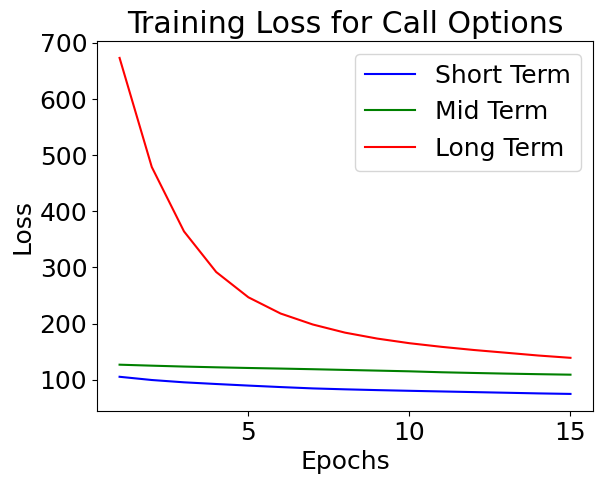

In [ ]:
# Extract the loss values from the training history
loss_call_short = history_call_short.history['loss']
loss_call_mid = history_call_mid.history['loss']
loss_call_long = history_call_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_call_short) + 1)
plt.plot(epochs, loss_call_short, 'b-', label='Short Term')
plt.plot(epochs, loss_call_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_call_long, 'r-', label='Long Term')
plt.title('Training Loss for Call Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Increasing the complexity of the LSTM mode

> Increasing the number of LSTM units to 100 in the first and second layers, added dropout layers after each LSTM layer, and applied the ReLU activation function.


1.   It starts with an LSTM layer of 100 units, with L2 regularization, and the ability to return sequences. This means that the LSTM layer will return the full sequence to the next layer.

1.   A dropout layer with a rate of 0.2 is added for regularization.
2.   A second LSTM layer of 100 units is added, followed by another dropout layer.
1.   A final LSTM layer of 50 units is added without returning sequences.
2.   A dense layer is then added with a single unit to provide the option's price.

1.   **Specifying the Optimizer**: An instance of the Adam optimizer is created with a learning rate of 0.001
2.   **Model Compilation**: Using the mean squared error (MSE) loss and the defined Adam optimizer.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    return model

# Build the LSTM models for call options - Short, Mid, and Long term
lstm_model_call_short = build_lstm_model((1, X_train_call_short_reshaped.shape[2]))
lstm_model_call_mid = build_lstm_model((1, X_train_call_mid_reshaped.shape[2]))
lstm_model_call_long = build_lstm_model((1, X_train_call_long_reshaped.shape[2]))

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the models with the specified optimizer
lstm_model_call_short.compile(loss='mse', optimizer=optimizer)
lstm_model_call_mid.compile(loss='mse', optimizer=optimizer)
lstm_model_call_long.compile(loss='mse', optimizer=optimizer)


**Learning Rate Scheduler**


> A learning rate scheduler is defined to adjust the learning rate during training. This function reduces the learning rate by half every five epochs, which can be useful to achieve more refined training as epochs progress.

In [ ]:
from keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr *= 0.5  # Reduce learning rate by a factor of 0.5 every 5 epochs
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)


**Training Data Splitting**


> A segment of the training data (20%) is set aside for validation to monitor the model's performance on unseen data during training

**Model Training**


> The model for short-term call options is trained with the defined learning rate scheduler. The training utilizes both training and validation data




In [ ]:
# Split your training data into training and validation sets - Short Term
X_train_call_short_8, X_val_call_short, y_train_call_short_8, y_val_call_short = train_test_split(
    X_train_call_short_reshaped, y_train_call_short, test_size=0.2, random_state=42
)

# Train the model for call options - Short term with validation split
print("call options - Short term: ")
history_call_short = lstm_model_call_short.fit(
    X_train_call_short_8, y_train_call_short_8,
    epochs=15, batch_size=32,
    validation_data=(X_val_call_short, y_val_call_short),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)


call options - Short term: 
Epoch 1/15
44620/44620 [==============================] - 288s 6ms/step - loss: 53578.3359 - val_loss: 7301.3008 - lr: 0.0010
Epoch 2/15
44620/44620 [==============================] - 282s 6ms/step - loss: 2934.0806 - val_loss: 1071.9423 - lr: 0.0010
Epoch 3/15
44620/44620 [==============================] - 283s 6ms/step - loss: 674.1956 - val_loss: 348.3348 - lr: 0.0010
Epoch 4/15
44620/44620 [==============================] - 302s 7ms/step - loss: 392.0600 - val_loss: 215.3548 - lr: 0.0010
Epoch 5/15
44620/44620 [==============================] - 279s 6ms/step - loss: 328.8484 - val_loss: 186.8969 - lr: 0.0010
Epoch 6/15
44620/44620 [==============================] - 283s 6ms/step - loss: 265.5166 - val_loss: 147.2503 - lr: 5.0000e-04
Epoch 7/15
44620/44620 [==============================] - 283s 6ms/step - loss: 250.3850 - val_loss: 186.8371 - lr: 5.0000e-04
Epoch 8/15
44620/44620 [==============================] - 303s 7ms/step - loss: 242.1097 - val_los

### Observations:
1.   **Model Architecture**: Three LSTM layers were used. The first two layers had return_sequences=True, indicating they passed the sequences to the next LSTM layer. The third LSTM layer didn't return sequences, so the output was passed to the Dense layer.
Dropout was applied after each of the first two LSTM layers to avoid overfitting.
L2 regularization was applied to the kernels of the LSTM layers.

1.   **Learning Rate Scheduler**: The learning rate was halved every 5 epochs, which probably helped the model converge faster, as a reduced learning rate can lead to more precise updates, especially when we're close to the optima.

2.   **Training Performance**: The model started with a relatively high training and validation loss, but they decreased significantly over epochs.
From epoch 6 onwards, the learning rate was reduced due to the scheduler, which likely aided in the model's convergence.
By the 15th epoch, the training loss was around 191.03 and the validation loss was approximately 112.72. The model seems to have reached a somewhat stable point, but it's not guaranteed that additional epochs wouldn't further improve the performance.

### Trying without the learning rate scheduler:
**Short Term:**

In [ ]:
# Split your training data into training and validation sets - Short Term
X_train_call_short_8, X_val_call_short, y_train_call_short_8, y_val_call_short = train_test_split(
    X_train_call_short_reshaped, y_train_call_short, test_size=0.2, random_state=42
)

# Train the model for call options - Short term with validation split
print("call options - Short term: ")
history_call_short = lstm_model_call_short.fit(
    X_train_call_short_8, y_train_call_short_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_call_short, y_val_call_short)
)

call options - Short term: 
Epoch 1/10
44620/44620 [==============================] - 352s 8ms/step - loss: 53485.7695 - val_loss: 7261.8472
Epoch 2/10
44620/44620 [==============================] - 344s 8ms/step - loss: 2921.6428 - val_loss: 946.0406
Epoch 3/10
44620/44620 [==============================] - 339s 8ms/step - loss: 670.5468 - val_loss: 359.5071
Epoch 4/10
44620/44620 [==============================] - 349s 8ms/step - loss: 391.4620 - val_loss: 287.7091
Epoch 5/10
44620/44620 [==============================] - 345s 8ms/step - loss: 327.8000 - val_loss: 218.2436
Epoch 6/10
44620/44620 [==============================] - 341s 8ms/step - loss: 301.2078 - val_loss: 179.1136
Epoch 7/10
44620/44620 [==============================] - 338s 8ms/step - loss: 283.2315 - val_loss: 198.8324
Epoch 8/10
44620/44620 [==============================] - 329s 7ms/step - loss: 270.6997 - val_loss: 191.4170
Epoch 9/10
44620/44620 [==============================] - 331s 7ms/step - loss: 264.0615

### Observations:
1.   **Stable Loss**: The training loss starts at 190.33 in epoch 1 and decreases to 181.71 by epoch 10. This shows a consistent but gradual decrease in the training loss. It indicates that the model is still learning, but the rate of improvement has slowed down compared to the first 15 epochs with the scheduler.

1.   **Validation Loss Fluctuations**: The validation loss starts at 99.26 in epoch 1 and achieves its lowest at 96.67 by epoch 10. While this is a good sign, there are some fluctuations in between (for example, it increases to 114.61 in epoch 3). This could mean that the model might be overfitting slightly, or it could be a result of the inherent noise in the validation set.

2.   **Comparison with Previous Training**: Without the learning rate scheduler, the model seems to achieve a slightly better validation loss in 10 epochs compared to the previous training.

**Mid Term:**

In [ ]:
# Split your training data into training and validation sets - Mid Term
X_train_call_mid_8, X_val_call_mid, y_train_call_mid_8, y_val_call_mid = train_test_split(
    X_train_call_mid_reshaped, y_train_call_mid, test_size=0.2, random_state=42
)

# Train the model for call options - Mid term with validation split
print("call options - Mid term: ")
history_call_mid = lstm_model_call_mid.fit(
    X_train_call_mid_8, y_train_call_mid_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_call_mid, y_val_call_mid),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)


call options - Mid term: 
Epoch 1/10
102589/102589 [==============================] - 659s 6ms/step - loss: 343818.6562 - val_loss: 310140.3750 - lr: 2.5000e-04
Epoch 2/10
102589/102589 [==============================] - 661s 6ms/step - loss: 308841.4375 - val_loss: 310135.8125 - lr: 2.5000e-04
Epoch 3/10
102589/102589 [==============================] - 658s 6ms/step - loss: 308842.6562 - val_loss: 310132.5312 - lr: 2.5000e-04
Epoch 4/10
102589/102589 [==============================] - 669s 7ms/step - loss: 308840.5312 - val_loss: 310136.2500 - lr: 2.5000e-04
Epoch 5/10
102589/102589 [==============================] - 661s 6ms/step - loss: 308842.6875 - val_loss: 310137.9688 - lr: 2.5000e-04
Epoch 6/10
102589/102589 [==============================] - 664s 6ms/step - loss: 308840.0938 - val_loss: 310134.2812 - lr: 1.2500e-04
Epoch 7/10
102589/102589 [==============================] - 710s 7ms/step - loss: 308840.0000 - val_loss: 310131.7188 - lr: 1.2500e-04
Epoch 8/10
102589/102589 [===

### Observations:

1.   **Consistent High Loss Values**: The loss values (both training and validation) are consistently high, showing no meaningful decline.

2.   **Minimal Loss Change**: The losses, over the epochs, do not show any significant change. The model isn't learning or improving its predictions.

1.   **Learning Rate Adjustments**: The learning rate does reduce after a certain point, but this reduction doesn't lead to any noticeable improvement.

### Remove the LearningRateScheduler callback

In [ ]:
# Split your training data into training and validation sets - Mid Term
X_train_call_mid_8, X_val_call_mid, y_train_call_mid_8, y_val_call_mid = train_test_split(
    X_train_call_mid_reshaped, y_train_call_mid, test_size=0.2, random_state=42
)

# Train the model for call options - Mid term with validation split
print("call options - Mid term: ")
history_call_mid = lstm_model_call_mid.fit(
    X_train_call_mid_8, y_train_call_mid_8,
    epochs=10, batch_size=64,
    validation_data=(X_val_call_mid, y_val_call_mid)
)

call options - Mid term: 
Epoch 1/10
51295/51295 [==============================] - 457s 9ms/step - loss: 151287.7031 - val_loss: 22869.6230
Epoch 2/10
51295/51295 [==============================] - 446s 9ms/step - loss: 7830.5474 - val_loss: 1660.3298
Epoch 3/10
51295/51295 [==============================] - 455s 9ms/step - loss: 1042.1473 - val_loss: 415.6568
Epoch 4/10
51295/51295 [==============================] - 473s 9ms/step - loss: 553.0442 - val_loss: 283.8788
Epoch 5/10
51295/51295 [==============================] - 501s 10ms/step - loss: 468.2506 - val_loss: 205.0489
Epoch 6/10
51295/51295 [==============================] - 479s 9ms/step - loss: 436.6061 - val_loss: 256.2780
Epoch 7/10
51295/51295 [==============================] - 483s 9ms/step - loss: 420.3731 - val_loss: 184.9171
Epoch 8/10
51295/51295 [==============================] - 478s 9ms/step - loss: 409.9901 - val_loss: 184.0841
Epoch 9/10
51295/51295 [==============================] - 478s 9ms/step - loss: 402.3

### Observations:

1.   **Loss Stagnation**: Both training and validation loss are very stable and showing no improvement or decline across epochs. This means the model isn't learning.

1.   **High Magnitude of Loss**: The scale of the loss is relatively large, which may imply that the predictions are quite far off from the true values.

2.   **Batch Size**: Increasing the batch size didn't seem to impact the loss dynamics in any significant way.

**Long Term:**

In [ ]:
# Split your training data into training and validation sets - Long Term
X_train_call_long_8, X_val_call_long, y_train_call_long_8, y_val_call_long = train_test_split(
    X_train_call_long_reshaped, y_train_call_long, test_size=0.2, random_state=42
)

# Train the model for call options - Long term with validation split
print("call options - Long term: ")
history_call_long = lstm_model_call_long.fit(
    X_train_call_long_8, y_train_call_long_8,
    epochs=10, batch_size=64,
    validation_data=(X_val_call_long, y_val_call_long),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)

call options - Long term: 
Epoch 1/10
4119/4119 [==============================] - 40s 9ms/step - loss: 1114369.7500 - val_loss: 1103227.2500 - lr: 1.2500e-04
Epoch 2/10
4119/4119 [==============================] - 35s 8ms/step - loss: 1083174.3750 - val_loss: 1074139.7500 - lr: 1.2500e-04
Epoch 3/10
4119/4119 [==============================] - 33s 8ms/step - loss: 1054515.3750 - val_loss: 1045888.0000 - lr: 1.2500e-04
Epoch 4/10
4119/4119 [==============================] - 35s 8ms/step - loss: 1026682.8750 - val_loss: 1018458.3125 - lr: 1.2500e-04
Epoch 5/10
4119/4119 [==============================] - 32s 8ms/step - loss: 999681.0625 - val_loss: 991850.3125 - lr: 1.2500e-04
Epoch 6/10
4119/4119 [==============================] - 33s 8ms/step - loss: 979904.0625 - val_loss: 978790.0625 - lr: 6.2500e-05
Epoch 7/10
4119/4119 [==============================] - 33s 8ms/step - loss: 966958.8750 - val_loss: 965940.2500 - lr: 6.2500e-05
Epoch 8/10
4119/4119 [==============================] -

### Observations:

1.   **Decreasing Loss**: Both training and validation loss consistently decrease across epochs, indicating that the model is learning and improving its predictions. This is a promising sign.

1.   **High Magnitude of Loss**: The absolute values of the loss are large, but this might be dependent on the scale of your target variable. The decreasing trend is more significant than the absolute value.

2.   **Learning Rate Scheduler**: The LearningRateScheduler seems to be effective in this context, as we can observe that by the sixth epoch the learning rate is halved, which could help in fine-tuning the model weights.

1.   **Convergence**: Given the decreasing trend in both training and validation loss, the model might further benefit from more training epochs, provided that overfitting is monitored.

### Remove the LearningRateScheduler callback

In [ ]:
# Split your training data into training and validation sets - Long Term
X_train_call_long_8, X_val_call_long, y_train_call_long_8, y_val_call_long = train_test_split(
    X_train_call_long_reshaped, y_train_call_long, test_size=0.2, random_state=42
)

# Train the model for call options - Long term with validation split
print("call options - Long term: ")
history_call_long = lstm_model_call_long.fit(
    X_train_call_long_8, y_train_call_long_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_call_long, y_val_call_long)
)

call options - Long term: 
Epoch 1/10
8237/8237 [==============================] - 75s 8ms/step - loss: 885285.8125 - val_loss: 732882.6250
Epoch 2/10
8237/8237 [==============================] - 71s 9ms/step - loss: 636497.3125 - val_loss: 579119.1875
Epoch 3/10
8237/8237 [==============================] - 69s 8ms/step - loss: 555544.7500 - val_loss: 553333.5000
Epoch 4/10
8237/8237 [==============================] - 71s 9ms/step - loss: 547937.3750 - val_loss: 552803.8750
Epoch 5/10
8237/8237 [==============================] - 68s 8ms/step - loss: 440466.3125 - val_loss: 290487.4688
Epoch 6/10
8237/8237 [==============================] - 69s 8ms/step - loss: 233288.2031 - val_loss: 187933.2500
Epoch 7/10
8237/8237 [==============================] - 68s 8ms/step - loss: 151683.9375 - val_loss: 122941.1797
Epoch 8/10
8237/8237 [==============================] - 74s 9ms/step - loss: 99247.3984 - val_loss: 80589.4766
Epoch 9/10
8237/8237 [==============================] - 68s 8ms/step - 

### Observations:

1.   **Decreasing Loss**: Both training and validation loss consistently decrease across epochs, similar to the results when the LearningRateScheduler was present. The model continues to learn and improve its predictions.

1.   **Training Speed**: The epochs take slightly less time to execute with the batch size of 32 (as compared to 64). The increase in the number of batches (due to reduced batch size) might enhance the gradient updates.

2.   **Loss Magnitude**: As before, the absolute values of the loss are large. However, as mentioned previously, the decreasing trend is more significant than the absolute value.

1.   **Learning Without Scheduler**: Even without the LearningRateScheduler, the model is progressing well. This indicates that the fixed learning rate chosen by the optimizer is suitable for this task, at least for the initial epochs.

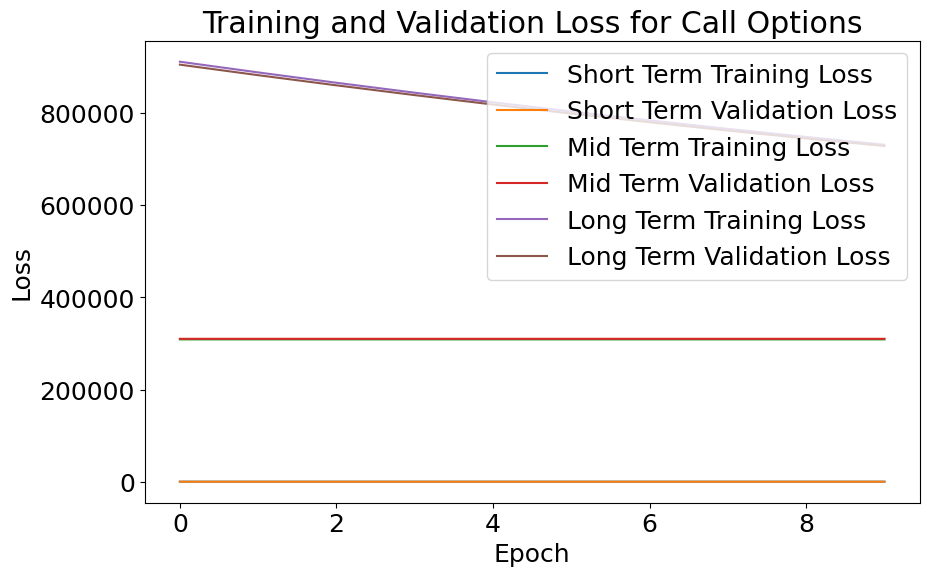

In [ ]:
# Plot training and validation loss for all three models
plt.figure(figsize=(10, 6))
plt.plot(history_call_short.history['loss'], label='Short Term Training Loss')
plt.plot(history_call_short.history['val_loss'], label='Short Term Validation Loss')
plt.plot(history_call_mid.history['loss'], label='Mid Term Training Loss')
plt.plot(history_call_mid.history['val_loss'], label='Mid Term Validation Loss')
plt.plot(history_call_long.history['loss'], label='Long Term Training Loss')
plt.plot(history_call_long.history['val_loss'], label='Long Term Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Call Options')
plt.legend()
plt.show()

## 3.1.2 LSTM put

**Data Reshaping**:
> Reshaping the data into 3-dimensional arrays for neural network models.

In [ ]:
# Reshape the input data to be 3-dimensional for LSTM (samples, time steps, features) - Put options - Short term
X_train_put_short_reshaped = np.reshape(X_train_put_short_scaled, (X_train_put_short_scaled.shape[0], 1, X_train_put_short_scaled.shape[1]))
X_test_put_short_reshaped = np.reshape(X_test_put_short_scaled, (X_test_put_short_scaled.shape[0], 1, X_test_put_short_scaled.shape[1]))

# Reshape the input data to be 3-dimensional for LSTM (samples, time steps, features) - Put options - Mid term
X_train_put_mid_reshaped = np.reshape(X_train_put_mid_scaled, (X_train_put_mid_scaled.shape[0], 1, X_train_put_mid_scaled.shape[1]))
X_test_put_mid_reshaped = np.reshape(X_test_put_mid_scaled, (X_test_put_mid_scaled.shape[0], 1, X_test_put_mid_scaled.shape[1]))

# Reshape the input data to be 3-dimensional for LSTM (samples, time steps, features) - Put options - Long term
X_train_put_long_reshaped = np.reshape(X_train_put_long_scaled, (X_train_put_long_scaled.shape[0], 1, X_train_put_long_scaled.shape[1]))
X_test_put_long_reshaped = np.reshape(X_test_put_long_scaled, (X_test_put_long_scaled.shape[0], 1, X_test_put_long_scaled.shape[1]))

**Build the LSTM model**
> constructing Long Short-Term Memory (LSTM) neural network models to price call options for three different time horizons: short term, mid term, and long term.

1.   Initiating the model using the Sequential class.
2.   Adding an LSTM layer with 50 units, and the input shape indicates that each sample has a single timestep with a set number of features.

1.   Appending a Dense output layer with one neuron, which will output the price of the call option.
2.   The model is compiled using the Mean Squared Error (MSE) as the loss function (suitable for regression problems like pricing) and the Adam optimizer.


In [ ]:
# Build the LSTM model for put options - Short term
lstm_model_put_short = Sequential()
lstm_model_put_short.add(LSTM(50, input_shape=(1, X_train_put_short_reshaped.shape[2])))
lstm_model_put_short.add(Dense(1))

# Compile the model
lstm_model_put_short.compile(loss='mse', optimizer='adam')

# Build the LSTM model for put options - Mid term
lstm_model_put_mid = Sequential()
lstm_model_put_mid.add(LSTM(50, input_shape=(1, X_train_put_mid_reshaped.shape[2])))
lstm_model_put_mid.add(Dense(1))

# Compile the model
lstm_model_put_mid.compile(loss='mse', optimizer='adam')

# Build the LSTM model for put options - Long term
lstm_model_put_long = Sequential()
lstm_model_put_long.add(LSTM(50, input_shape=(1, X_train_put_long_reshaped.shape[2])))
lstm_model_put_long.add(Dense(1))

# Compile the model
lstm_model_put_long.compile(loss='mse', optimizer='adam')

In [ ]:
import matplotlib.pyplot as plt

# Train the model for put options - short term
print("put options - Short term: ")
history_put_short = lstm_model_put_short.fit(X_train_put_short_reshaped, y_train_put_short, epochs=10, batch_size=32)

# Train the model for put options - mid term
print("put options - Mid term: ")
history_put_mid = lstm_model_put_mid.fit(X_train_put_mid_reshaped, y_train_put_mid, epochs=10, batch_size=32)

# Train the model for put options - long term
print("put options - Long term: ")
history_put_long = lstm_model_put_long.fit(X_train_put_long_reshaped, y_train_put_long, epochs=10, batch_size=32)

put options - Short term: 
Epoch 1/10
59684/59684 [==============================] - 150s 2ms/step - loss: 11354.4473
Epoch 2/10
59684/59684 [==============================] - 145s 2ms/step - loss: 681.4526
Epoch 3/10
59684/59684 [==============================] - 147s 2ms/step - loss: 216.7729
Epoch 4/10
59684/59684 [==============================] - 142s 2ms/step - loss: 145.4108
Epoch 5/10
59684/59684 [==============================] - 143s 2ms/step - loss: 114.6610
Epoch 6/10
59684/59684 [==============================] - 143s 2ms/step - loss: 97.4139
Epoch 7/10
59684/59684 [==============================] - 143s 2ms/step - loss: 87.6261
Epoch 8/10
59684/59684 [==============================] - 144s 2ms/step - loss: 81.0733
Epoch 9/10
59684/59684 [==============================] - 142s 2ms/step - loss: 76.7762
Epoch 10/10
59684/59684 [==============================] - 142s 2ms/step - loss: 73.7051
put options - Mid term: 
Epoch 1/10
130610/130610 [==============================] - 

### Observations:


1.   **Rate of Convergence**: All models show a rapid decline in loss in the initial epochs. This indicates that the models quickly adapt to the underlying patterns in the data.

2.   **Loss Magnitude**: As observed previously, the absolute values of the loss are large, particularly for the long-term model. However, as mentioned before, the decreasing trend is more significant than the absolute value.

1.   **Training Speed**: The models' training time per epoch varies, with the mid-term model taking the longest time due to more data points.



In [ ]:
# # Predict option prices using the trained LSTM models
# predicted_put_prices_lstm_short = lstm_model_put_short.predict(X_test_put_short_reshaped)
# predicted_put_prices_lstm_mid = lstm_model_put_mid.predict(X_test_put_mid_reshaped)
# predicted_put_prices_lstm_long = lstm_model_put_long.predict(X_test_put_long_reshaped)

# # Print or use the predicted option prices as needed
# print("Predicted Put Option Prices - Short Term:")
# print(predicted_put_prices_lstm_short)
# print("Predicted Put Option Prices - Mid Term:")
# print(predicted_put_prices_lstm_mid)
# print("Predicted Put Option Prices - Long Term:")
# print(predicted_put_prices_lstm_long)

2978/2978 [==============================] - 5s 1ms/step
Predicted Put Option Prices - Short Term:
[[117.609566 ]
 [ -1.1213608]
 [ -2.4309464]
 ...
 [145.86105  ]
 [ 91.87604  ]
 [ 91.161064 ]]
Predicted Put Option Prices - Mid Term:
[[  1.3503113]
 [  2.7066994]
 [ 39.343216 ]
 ...
 [  7.941677 ]
 [ 18.492977 ]
 [124.85681  ]]
Predicted Put Option Prices - Long Term:
[[ 29.192001 ]
 [  3.7306824]
 [307.9937   ]
 ...
 [105.90194  ]
 [643.2418   ]
 [257.1909   ]]


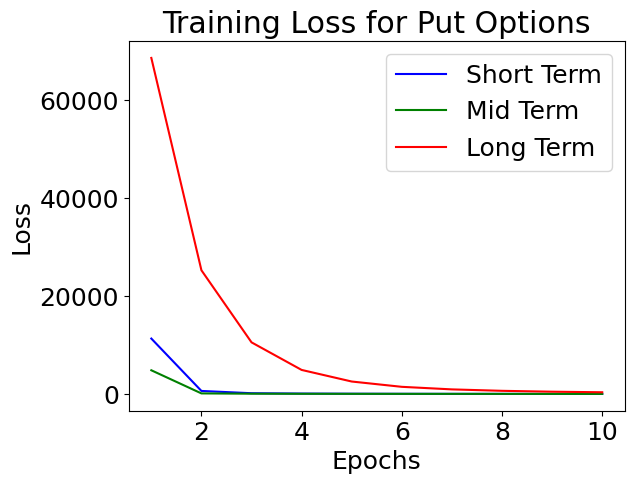

In [ ]:
# Extract the loss values from the training history
loss_put_short = history_put_short.history['loss']
loss_put_mid = history_put_mid.history['loss']
loss_put_long = history_put_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_put_short) + 1)
plt.plot(epochs, loss_put_short, 'b-', label='Short Term')
plt.plot(epochs, loss_put_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_put_long, 'r-', label='Long Term')
plt.title('Training Loss for Put Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Increasing the complexity of the LSTM mode

> Increasing the number of LSTM units to 100 in the first and second layers, added dropout layers after each LSTM layer, and applied the ReLU activation function.


1.   It starts with an LSTM layer of 100 units, with L2 regularization, and the ability to return sequences. This means that the LSTM layer will return the full sequence to the next layer.

1.   A dropout layer with a rate of 0.2 is added for regularization.
2.   A second LSTM layer of 100 units is added, followed by another dropout layer.
1.   A final LSTM layer of 50 units is added without returning sequences.
2.   A dense layer is then added with a single unit to provide the option's price.

1.   **Specifying the Optimizer**: An instance of the Adam optimizer is created with a learning rate of 0.001
2.   **Model Compilation**: Using the mean squared error (MSE) loss and the defined Adam optimizer.

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    return model

# Build the LSTM models for put options - Short, Mid, and Long term
lstm_model_put_short = build_lstm_model((1, X_train_put_short_reshaped.shape[2]))
lstm_model_put_mid = build_lstm_model((1, X_train_put_mid_reshaped.shape[2]))
lstm_model_put_long = build_lstm_model((1, X_train_put_long_reshaped.shape[2]))

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the models with the specified optimizer
lstm_model_put_short.compile(loss='mse', optimizer=optimizer)
lstm_model_put_mid.compile(loss='mse', optimizer=optimizer)
lstm_model_put_long.compile(loss='mse', optimizer=optimizer)


**Short Term:**

In [ ]:
# Split your training data into training and validation sets
X_train_put_short_8, X_val_put_short, y_train_put_short_8, y_val_put_short = train_test_split(
    X_train_put_short_reshaped, y_train_put_short, test_size=0.2, random_state=42
)

# Train the model for put options - Short term with validation split
print("put options - Short term: ")
history_put_short = lstm_model_put_short.fit(
    X_train_put_short_8, y_train_put_short_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_put_short, y_val_put_short),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)

put options - Short term: 
Epoch 1/10
47748/47748 [==============================] - 329s 7ms/step - loss: 8956.7236 - val_loss: 1834.8153 - lr: 0.0010
Epoch 2/10
47748/47748 [==============================] - 325s 7ms/step - loss: 900.4952 - val_loss: 322.2990 - lr: 0.0010
Epoch 3/10
47748/47748 [==============================] - 318s 7ms/step - loss: 271.6831 - val_loss: 208.2350 - lr: 0.0010
Epoch 4/10
47748/47748 [==============================] - 319s 7ms/step - loss: 185.7852 - val_loss: 101.6518 - lr: 0.0010
Epoch 5/10
47748/47748 [==============================] - 317s 7ms/step - loss: 167.1185 - val_loss: 123.7841 - lr: 0.0010
Epoch 6/10
47748/47748 [==============================] - 324s 7ms/step - loss: 135.1287 - val_loss: 83.3926 - lr: 5.0000e-04
Epoch 7/10
47748/47748 [==============================] - 321s 7ms/step - loss: 129.2900 - val_loss: 103.8695 - lr: 5.0000e-04
Epoch 8/10
47748/47748 [==============================] - 318s 7ms/step - loss: 126.0828 - val_loss: 93

### Observations:


1.   The initial loss for the model is 8956.7236, which drops significantly in the following epochs, suggesting the model is learning.

2.   By the 6th epoch, there’s a noticeable decrease in the learning rate, and a corresponding sharp decrease in loss. This might indicate that the learning rate scheduler effectively helps in honing into a local minimum.

1.   The validation loss seems to be improving over the epochs, which means the model isn't just memorizing the training data but is generalizing well.

### Remove the LearningRateScheduler callback

In [ ]:
# Split your training data into training and validation sets
X_train_put_short_8, X_val_put_short, y_train_put_short_8, y_val_put_short = train_test_split(
    X_train_put_short_reshaped, y_train_put_short, test_size=0.2, random_state=42
)

# Train the model for put options - Short term with validation split
print("put options - Short term: ")
history_put_short = lstm_model_put_short.fit(
    X_train_put_short_8, y_train_put_short_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_put_short, y_val_put_short)
)


put options - Short term: 
Epoch 1/10
47748/47748 [==============================] - 405s 8ms/step - loss: 9013.3867 - val_loss: 1883.2034
Epoch 2/10
47748/47748 [==============================] - 402s 8ms/step - loss: 907.1110 - val_loss: 340.1606
Epoch 3/10
47748/47748 [==============================] - 400s 8ms/step - loss: 287.2997 - val_loss: 186.8840
Epoch 4/10
47748/47748 [==============================] - 406s 9ms/step - loss: 187.8282 - val_loss: 126.3054
Epoch 5/10
47748/47748 [==============================] - 396s 8ms/step - loss: 165.4705 - val_loss: 122.3494
Epoch 6/10
47748/47748 [==============================] - 396s 8ms/step - loss: 157.8043 - val_loss: 93.5598
Epoch 7/10
47748/47748 [==============================] - 393s 8ms/step - loss: 153.1792 - val_loss: 91.6248
Epoch 8/10
47748/47748 [==============================] - 394s 8ms/step - loss: 150.5370 - val_loss: 80.3397
Epoch 9/10
47748/47748 [==============================] - 397s 8ms/step - loss: 147.8572 - val

### Observations:


1.   Implementing the validation set gives a more holistic view of the model's performance. The relatively close values of training and validation loss indicate that the model is generalizing well, which is promising for its performance on completely unseen test data.

2.  The significant drop in training and validation loss across epochs indicates that the model is learning effectively.

**Mid Term:**

In [ ]:
# Split your training data into training and validation sets
X_train_put_mid_8, X_val_put_mid, y_train_put_mid_8, y_val_put_mid = train_test_split(
    X_train_put_mid_reshaped, y_train_put_mid, test_size=0.2, random_state=42
)

# Train the model for put options - Mid term with validation split
print("put options - Mid term: ")
history_put_mid = lstm_model_put_mid.fit(
    X_train_put_mid_8, y_train_put_mid_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_put_mid, y_val_put_mid),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)


put options - Mid term: 
Epoch 1/10
104488/104488 [==============================] - 712s 7ms/step - loss: 7490.4214 - val_loss: 1171.5729 - lr: 5.0000e-04
Epoch 2/10
104488/104488 [==============================] - 722s 7ms/step - loss: 707.8666 - val_loss: 365.7399 - lr: 5.0000e-04
Epoch 3/10
104488/104488 [==============================] - 725s 7ms/step - loss: 360.2795 - val_loss: 230.4345 - lr: 5.0000e-04
Epoch 4/10
104488/104488 [==============================] - 713s 7ms/step - loss: 281.9701 - val_loss: 167.2680 - lr: 5.0000e-04
Epoch 5/10
104488/104488 [==============================] - 712s 7ms/step - loss: 243.5068 - val_loss: 156.7548 - lr: 5.0000e-04
Epoch 6/10
104488/104488 [==============================] - 715s 7ms/step - loss: 210.3266 - val_loss: 133.8446 - lr: 2.5000e-04
Epoch 7/10
104488/104488 [==============================] - 695s 7ms/step - loss: 201.7938 - val_loss: 129.6921 - lr: 2.5000e-04
Epoch 8/10
104488/104488 [==============================] - 695s 7ms/s

### Observations:
1.   **Learning**: The model appears to be learning effectively as indicated by the decreasing training and validation losses.

2.   **Learning Rate**: The use of LearningRateScheduler suggests that dynamic adjustment of the learning rate can aid the training process. The reduction in learning rate after five epochs might have been triggered due to some conditions set in the scheduler. The losses after the adjustment continue to decrease, which supports the decision to reduce the learning rate.

1.  **Generalization**: There's no clear sign of overfitting, as both training and validation losses decrease somewhat consistently. However, you should always be wary of potential overfitting, especially if the model becomes too complex or is trained for too many epochs.

### Remove the LearningRateScheduler callback

In [ ]:
# Split your training data into training and validation sets
X_train_put_mid_8, X_val_put_mid, y_train_put_mid_8, y_val_put_mid = train_test_split(
    X_train_put_mid_reshaped, y_train_put_mid, test_size=0.2, random_state=42
)

# Train the model for put options - Mid term with validation split
print("put options - Mid term: ")
history_put_mid = lstm_model_put_mid.fit(
    X_train_put_mid_8, y_train_put_mid_8,
    epochs=10, batch_size=32,
    validation_data=(X_val_put_mid, y_val_put_mid)
)

put options - Mid term: 
Epoch 1/10
104488/104488 [==============================] - 878s 8ms/step - loss: 4094.4119 - val_loss: 373.8579
Epoch 2/10
104488/104488 [==============================] - 888s 8ms/step - loss: 358.3410 - val_loss: 256.4865
Epoch 3/10
104488/104488 [==============================] - 875s 8ms/step - loss: 282.1873 - val_loss: 165.9049
Epoch 4/10
104488/104488 [==============================] - 869s 8ms/step - loss: 259.7586 - val_loss: 154.5085
Epoch 5/10
104488/104488 [==============================] - 859s 8ms/step - loss: 248.2114 - val_loss: 161.6745
Epoch 6/10
104488/104488 [==============================] - 851s 8ms/step - loss: 239.3914 - val_loss: 154.2754
Epoch 7/10
104488/104488 [==============================] - 826s 8ms/step - loss: 233.7992 - val_loss: 149.8776
Epoch 8/10
104488/104488 [==============================] - 837s 8ms/step - loss: 230.1204 - val_loss: 187.7409
Epoch 9/10
104488/104488 [==============================] - 829s 8ms/step - lo

### Observations:
1.   **Learning**: Similar to the prior analysis, the model seems to be learning as indicated by the consistent decrease in training loss. The absence of the LearningRateScheduler hasn't detrimentally impacted the learning process.

2.   **Validation Loss Fluctuation**: While the validation loss generally decreases, there are epochs where it increases (like epoch 5 to 6). These fluctuations suggest that the model might be over-optimizing on the training data, causing a slight degradation in performance on the validation set during those epochs.

1.  **Generalization**: The model still seems to generalize well to the validation set, but there are slight signs of overfitting when observing the fluctuations in the validation loss.

**Long Term:**

In [ ]:
# Split your training data into training and validation sets
X_train_put_long_8, X_val_put_long, y_train_put_long_8, y_val_put_long = train_test_split(
    X_train_put_long_reshaped, y_train_put_long, test_size=0.2, random_state=42
)

# Train the model for put options - Long term with validation split
print("put options - Long term: ")
history_put_long = lstm_model_put_long.fit(
    X_train_put_long_8, y_train_put_long_8,
    epochs=20, batch_size=32,
    validation_data=(X_val_put_long, y_val_put_long),
    callbacks=[lr_scheduler]  # Add the LearningRateScheduler callback
)


put options - Long term: 
Epoch 1/20
8347/8347 [==============================] - 63s 7ms/step - loss: 96453.7422 - val_loss: 85399.5156 - lr: 2.5000e-04
Epoch 2/20
8347/8347 [==============================] - 59s 7ms/step - loss: 74071.7188 - val_loss: 65711.2109 - lr: 2.5000e-04
Epoch 3/20
8347/8347 [==============================] - 59s 7ms/step - loss: 57695.4492 - val_loss: 51426.5000 - lr: 2.5000e-04
Epoch 4/20
8347/8347 [==============================] - 57s 7ms/step - loss: 45275.2383 - val_loss: 40495.1836 - lr: 2.5000e-04
Epoch 5/20
8347/8347 [==============================] - 57s 7ms/step - loss: 35745.1914 - val_loss: 32119.3594 - lr: 2.5000e-04
Epoch 6/20
8347/8347 [==============================] - 56s 7ms/step - loss: 30008.8711 - val_loss: 28628.3633 - lr: 1.2500e-04
Epoch 7/20
8347/8347 [==============================] - 56s 7ms/step - loss: 26751.7012 - val_loss: 25558.2422 - lr: 1.2500e-04
Epoch 8/20
8347/8347 [==============================] - 57s 7ms/step - loss: 2

### Observations:
1.   **Learning**: The model appears to be effectively learning from the data. The validation loss closely mirrors the training loss, suggesting a good generalization to unseen data.

2.   **No Overfitting**: Given that validation loss decreases consistently with the training loss without diverging, there's no obvious sign of overfitting.

1.  **Benefit of Learning Rate Scheduler**: The scheduled decrease in learning rate seems beneficial. As the learning rate decreases, the model might make smaller adjustments, allowing for more refined optimization. This approach might be preventing the model from getting stuck in local minima and helping it navigate towards a better solution.

### Remove the LearningRateScheduler callback

In [ ]:
# Split your training data into training and validation sets
X_train_put_long_8, X_val_put_long, y_train_put_long_8, y_val_put_long = train_test_split(
    X_train_put_long_reshaped, y_train_put_long, test_size=0.2, random_state=42
)

# Train the model for put options - Long term with validation split
print("put options - Long term: ")
history_put_long = lstm_model_put_long.fit(
    X_train_put_long_8, y_train_put_long_8,
    epochs=20, batch_size=32,
    validation_data=(X_val_put_long, y_val_put_long)
)

put options - Long term: 
Epoch 1/20
8347/8347 [==============================] - 60s 7ms/step - loss: 12237.8682 - val_loss: 12233.5010
Epoch 2/20
8347/8347 [==============================] - 56s 7ms/step - loss: 11942.3262 - val_loss: 11936.0859
Epoch 3/20
8347/8347 [==============================] - 58s 7ms/step - loss: 11652.8623 - val_loss: 11646.6895
Epoch 4/20
8347/8347 [==============================] - 59s 7ms/step - loss: 11374.7764 - val_loss: 11369.7949
Epoch 5/20
8347/8347 [==============================] - 58s 7ms/step - loss: 11103.2002 - val_loss: 11096.1670
Epoch 6/20
8347/8347 [==============================] - 59s 7ms/step - loss: 10838.0312 - val_loss: 10831.3047
Epoch 7/20
8347/8347 [==============================] - 58s 7ms/step - loss: 10582.6807 - val_loss: 10574.0967
Epoch 8/20
8347/8347 [==============================] - 57s 7ms/step - loss: 10333.0684 - val_loss: 10325.0840
Epoch 9/20
8347/8347 [==============================] - 59s 7ms/step - loss: 10093.743

### Observations:
1.   **Effective Learning Without Scheduler**: The model appears to learn effectively even without the learning rate scheduler. This could be because the initial learning rate was suitable and didn't require adjustments during training.

2.   **Good Generalization**: The validation loss closely follows the training loss without diverging, indicating that the model is generalizing well to unseen data and not overfitting.

### Modifying the batch size to 64

In [ ]:
# Split your training data into training and validation sets
X_train_put_long_8, X_val_put_long, y_train_put_long_8, y_val_put_long = train_test_split(
    X_train_put_long_reshaped, y_train_put_long, test_size=0.2, random_state=42
)

# Train the model for put options - Long term with validation split
print("put options - Long term: ")
history_put_long = lstm_model_put_long.fit(
    X_train_put_long_8, y_train_put_long_8,
    epochs=20, batch_size=64,
    validation_data=(X_val_put_long, y_val_put_long)
)

put options - Long term: 
Epoch 1/20
4174/4174 [==============================] - 44s 9ms/step - loss: 79552.8906 - val_loss: 60162.3516
Epoch 2/20
4174/4174 [==============================] - 38s 9ms/step - loss: 47568.7852 - val_loss: 37845.7695
Epoch 3/20
4174/4174 [==============================] - 39s 9ms/step - loss: 30150.3926 - val_loss: 24188.4941
Epoch 4/20
4174/4174 [==============================] - 39s 9ms/step - loss: 19423.5488 - val_loss: 15762.4824
Epoch 5/20
4174/4174 [==============================] - 39s 9ms/step - loss: 12752.2803 - val_loss: 10417.3945
Epoch 6/20
4174/4174 [==============================] - 39s 9ms/step - loss: 8511.3252 - val_loss: 7004.6631
Epoch 7/20
4174/4174 [==============================] - 39s 9ms/step - loss: 5815.4731 - val_loss: 4849.4707
Epoch 8/20
4174/4174 [==============================] - 38s 9ms/step - loss: 4087.6272 - val_loss: 3469.6077
Epoch 9/20
4174/4174 [==============================] - 39s 9ms/step - loss: 2979.3464 - val

### Observations:
1.   **Computational Efficiency**: Increasing the batch size has reduced the training time per epoch. Bigger batches can leverage vectorized operations better, leading to faster computation.

2.   **Smooth Learning**: The consistent decrease in loss suggests that the model is still learning and hasn't stagnated or plateaued.

1.  **Good Generalization**: Like before, the validation loss closely follows the training loss, indicating that the model is generalizing well.

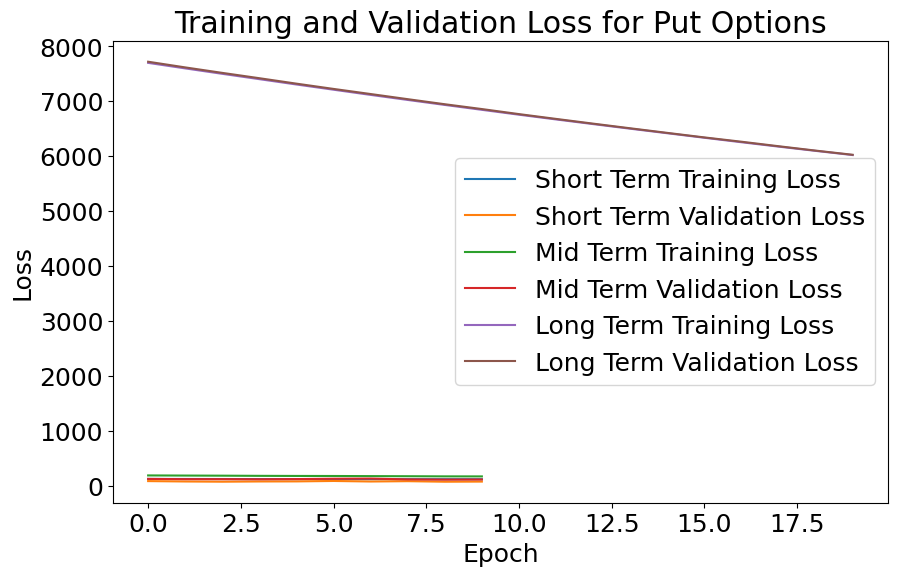

In [ ]:
# Plot training and validation loss for all three models
plt.figure(figsize=(10, 6))
plt.plot(history_put_short.history['loss'], label='Short Term Training Loss')
plt.plot(history_put_short.history['val_loss'], label='Short Term Validation Loss')
plt.plot(history_put_mid.history['loss'], label='Mid Term Training Loss')
plt.plot(history_put_mid.history['val_loss'], label='Mid Term Validation Loss')
plt.plot(history_put_long.history['loss'], label='Long Term Training Loss')
plt.plot(history_put_long.history['val_loss'], label='Long Term Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Put Options')
plt.legend()
plt.show()

## 3.2 RNN

## 3.2.1 RNN call

### Build the RNN model
Model Architecture:


1.   **SimpleRNN Layer**: This is the recurrent layer of the model. The number of recurrent neurons or units in this layer is 50.
2.   **Dense Layer**: This is a fully connected layer that follows the RNN layer.

1.   **Compilation**: Using the Mean Squared Error as loss function. 'Adam' is used as the optimizer.
2.   **Training**: The model is trained for 10 iterations over the entire dataset.And the batch size is 32.

In [ ]:
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler

# Build the RNN model for call options - Short term
rnn_model_call_short = Sequential()
rnn_model_call_short.add(SimpleRNN(50, input_shape=(X_train_call_short_reshaped.shape[1], X_train_call_short_reshaped.shape[2])))
rnn_model_call_short.add(Dense(1))

# Compile the model
rnn_model_call_short.compile(loss='mse', optimizer='adam')

print("put options - Short term: ")
# Train the RNN model for call options
history_call_rnn_short = rnn_model_call_short.fit(X_train_call_short_reshaped, y_train_call_short, epochs=10, batch_size=32)



# Build the RNN model for call options - Mid term
rnn_model_call_mid = Sequential()
rnn_model_call_mid.add(SimpleRNN(50, input_shape=(X_train_call_mid_reshaped.shape[1], X_train_call_mid_reshaped.shape[2])))
rnn_model_call_mid.add(Dense(1))

# Compile the model
rnn_model_call_mid.compile(loss='mse', optimizer='adam')

print("put options - Mid term: ")
# Train the RNN model for call options
history_call_rnn_mid = rnn_model_call_mid.fit(X_train_call_mid_reshaped, y_train_call_mid, epochs=10, batch_size=32)



# Build the RNN model for call options - Long term
rnn_model_call_long = Sequential()
rnn_model_call_long.add(SimpleRNN(50, input_shape=(X_train_call_long_reshaped.shape[1], X_train_call_long_reshaped.shape[2])))
rnn_model_call_long.add(Dense(1))

# Compile the model
rnn_model_call_long.compile(loss='mse', optimizer='adam')

print("put options - Long term: ")
# Train the RNN model for call options
history_call_rnn_long = rnn_model_call_long.fit(X_train_call_long_reshaped, y_train_call_long, epochs=10, batch_size=32)

put options - Short term: 
Epoch 1/10
55775/55775 [==============================] - 93s 2ms/step - loss: 45488.3438
Epoch 2/10
55775/55775 [==============================] - 93s 2ms/step - loss: 1115.2074
Epoch 3/10
55775/55775 [==============================] - 93s 2ms/step - loss: 401.1272
Epoch 4/10
55775/55775 [==============================] - 94s 2ms/step - loss: 279.5571
Epoch 5/10
55775/55775 [==============================] - 94s 2ms/step - loss: 224.2190
Epoch 6/10
55775/55775 [==============================] - 92s 2ms/step - loss: 195.9926
Epoch 7/10
55775/55775 [==============================] - 92s 2ms/step - loss: 174.9184
Epoch 8/10
55775/55775 [==============================] - 93s 2ms/step - loss: 159.3667
Epoch 9/10
55775/55775 [==============================] - 92s 2ms/step - loss: 147.5276
Epoch 10/10
55775/55775 [==============================] - 91s 2ms/step - loss: 141.4792
put options - Mid term: 
Epoch 1/10
128236/128236 [==============================] - 214s

### Observations:
1.   For all three time horizons (short, mid, and long-term), the loss consistently decreased over epochs, indicating successful learning.

2.   The RNN models for the call options have learned patterns within their respective datasets.

1.  The long-term model sees a more drastic decrease in its loss values, which could suggest that its initial weights were farther from an optimal solution compared to the short and mid-term models. Another possibility is that the data for long-term options might have more pronounced patterns or trends that the model quickly picks up on.

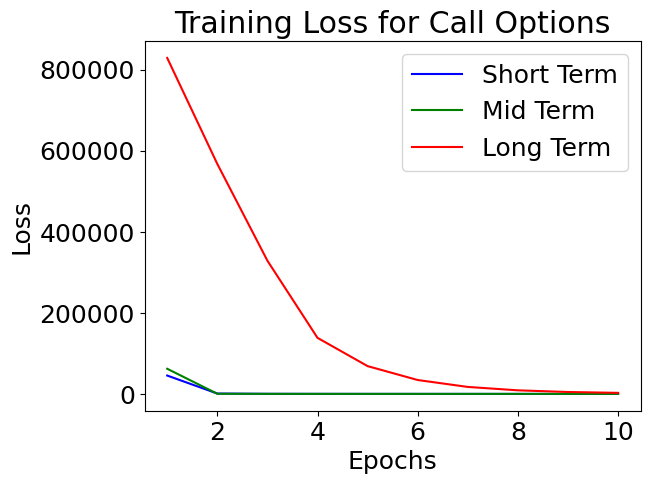

In [ ]:
# Extract the loss values from the training history
loss_call_short = history_call_rnn_short.history['loss']
loss_call_mid = history_call_rnn_mid.history['loss']
loss_call_long = history_call_rnn_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_call_short) + 1)
plt.plot(epochs, loss_call_short, 'b-', label='Short Term')
plt.plot(epochs, loss_call_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_call_long, 'r-', label='Long Term')
plt.title('Training Loss for Call Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Increasing the complexity of the RNN model by adding multiple layers

1.   The input data goes into the first SimpleRNN layer with 50 units (or cells), which processes the input and returns sequences. These sequences are the outputs for each time step.
2.   The sequences from the first layer are fed into the second SimpleRNN layer with 50 units. This second layer processes the sequences but does not return sequences; it only returns the final output.

1.   The output of the second SimpleRNN layer is then processed by a Dense layer with a single unit to produce the final output.

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Build the RNN model for call options
rnn_model_call_short = Sequential()
rnn_model_call_short.add(SimpleRNN(50, input_shape=(X_train_call_short_reshaped.shape[1], X_train_call_short_reshaped.shape[2]), return_sequences=True))
rnn_model_call_short.add(SimpleRNN(50))
rnn_model_call_short.add(Dense(1))


# Compile the model
rnn_model_call_short.compile(loss='mse', optimizer='adam')

print("put options - Short term: ")
# Train the RNN model for call options
history_call_rnn_short = rnn_model_call_short.fit(X_train_call_short_reshaped, y_train_call_short, epochs=10, batch_size=32)


# Build the RNN model for call options
rnn_model_call_mid = Sequential()
rnn_model_call_mid.add(SimpleRNN(50, input_shape=(X_train_call_mid_reshaped.shape[1], X_train_call_mid_reshaped.shape[2]), return_sequences=True))
rnn_model_call_mid.add(SimpleRNN(50))
rnn_model_call_mid.add(Dense(1))

# Compile the model
rnn_model_call_mid.compile(loss='mse', optimizer='adam')

print("put options - Mid term: ")
# Train the RNN model for call options
history_call_rnn_mid = rnn_model_call_mid.fit(X_train_call_mid_reshaped, y_train_call_mid, epochs=10, batch_size=32)


# Build the RNN model for call options
rnn_model_call_long = Sequential()
rnn_model_call_long.add(SimpleRNN(50, input_shape=(X_train_call_long_reshaped.shape[1], X_train_call_long_reshaped.shape[2]), return_sequences=True))
rnn_model_call_long.add(SimpleRNN(50))
rnn_model_call_long.add(Dense(1))

# Compile the model
rnn_model_call_long.compile(loss='mse', optimizer='adam')

print("put options - Long term: ")
# Train the RNN model for call options
history_call_rnn_long = rnn_model_call_long.fit(X_train_call_long_reshaped, y_train_call_long, epochs=10, batch_size=32)

put options - Short term: 
Epoch 1/10
55775/55775 [==============================] - 135s 2ms/step - loss: 39067.3438
Epoch 2/10
55775/55775 [==============================] - 135s 2ms/step - loss: 708.8856
Epoch 3/10
55775/55775 [==============================] - 132s 2ms/step - loss: 164.3705
Epoch 4/10
55775/55775 [==============================] - 134s 2ms/step - loss: 108.6756
Epoch 5/10
55775/55775 [==============================] - 132s 2ms/step - loss: 92.0059
Epoch 6/10
55775/55775 [==============================] - 133s 2ms/step - loss: 82.2534
Epoch 7/10
55775/55775 [==============================] - 130s 2ms/step - loss: 75.3141
Epoch 8/10
55775/55775 [==============================] - 133s 2ms/step - loss: 70.4437
Epoch 9/10
55775/55775 [==============================] - 131s 2ms/step - loss: 67.2746
Epoch 10/10
55775/55775 [==============================] - 130s 2ms/step - loss: 65.3342
put options - Mid term: 
Epoch 1/10
128236/128236 [==============================] - 3

### Observations:
1.   **Short Term Model**: The two-layered RNN architecture performs better than the single-layered RNN. The loss is lower, indicating improved learning.

2.   **Mid Term Model**: Similarly, for the mid-term model, the two-layered RNN has shown a better reduction in loss compared to its single-layered counterpart.

1.  **Long Term Model**: The two-layered RNN has a slightly better performance for the long term model. Though the starting loss is a bit higher, by the end of the 10th epoch, it achieves a lower loss value compared to the single-layered model.

In [ ]:
# Predict option prices using the trained RNN models
predicted_call_prices_rnn_short = rnn_model_call_short.predict(X_test_call_short_reshaped)
predicted_call_prices_rnn_mid = rnn_model_call_mid.predict(X_test_call_mid_reshaped)
predicted_call_prices_rnn_long = rnn_model_call_long.predict(X_test_call_long_reshaped)

# Print or use the predicted option prices as needed
print("Predicted Call Option Prices - Short Term:")
print(predicted_call_prices_rnn_short)
print("Predicted Call Option Prices - Mid Term:")
print(predicted_call_prices_rnn_mid)
print("Predicted Call Option Prices - Long Term:")
print(predicted_call_prices_rnn_long)

2927/2927 [==============================] - 4s 1ms/step
Predicted Call Option Prices - Short Term:
[[ 1.5208508e+01]
 [ 4.3847351e+00]
 [-1.1986771e+00]
 ...
 [ 1.2806981e+03]
 [ 5.0348465e+02]
 [ 3.8966385e+02]]
Predicted Call Option Prices - Mid Term:
[[ 2.8764938e+02]
 [ 3.6903937e+02]
 [-4.5131683e-01]
 ...
 [ 1.1731184e+03]
 [ 6.5863611e+02]
 [ 2.8489727e+03]]
Predicted Call Option Prices - Long Term:
[[  29.482452]
 [ 167.45065 ]
 [ 664.1758  ]
 ...
 [1485.4374  ]
 [ 893.54395 ]
 [1431.7711  ]]


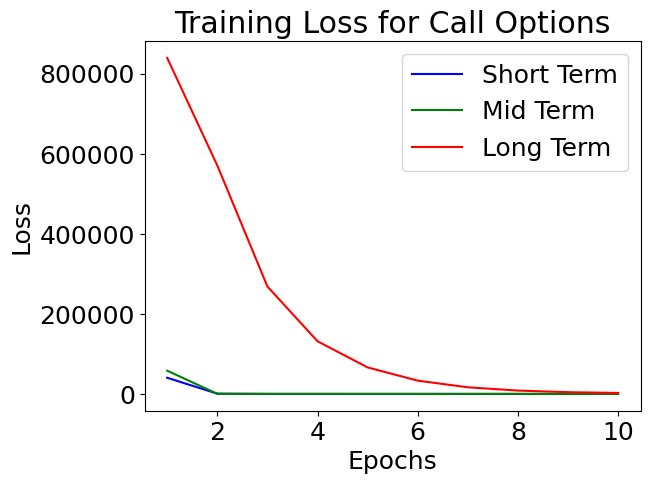

In [ ]:
# Extract the loss values from the training history
loss_call_short = history_call_rnn_short.history['loss']
loss_call_mid = history_call_rnn_mid.history['loss']
loss_call_long = history_call_rnn_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_call_short) + 1)
plt.plot(epochs, loss_call_short, 'b-', label='Short Term')
plt.plot(epochs, loss_call_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_call_long, 'r-', label='Long Term')
plt.title('Training Loss for Call Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3.2.2 RNN put

### Build the RNN model
Model Architecture:


1.   **SimpleRNN Layer**: This is the recurrent layer of the model. The number of recurrent neurons or units in this layer is 50.
2.   **Dense Layer**: This is a fully connected layer that follows the RNN layer.

1.   **Compilation**: Using the Mean Squared Error as loss function. 'Adam' is used as the optimizer.
2.   **Training**: The model is trained for 10 iterations over the entire dataset.And the batch size is 32.

In [ ]:
# Build the RNN model for put options - Short term
rnn_model_put_short = Sequential()
rnn_model_put_short.add(SimpleRNN(50, input_shape=(X_train_put_short_reshaped.shape[1], X_train_put_short_reshaped.shape[2])))
rnn_model_put_short.add(Dense(1))

# Compile the model
rnn_model_put_short.compile(loss='mse', optimizer='adam')

print("put options - Short term: ")
# Train the RNN model for put options
history_put_rnn_short = rnn_model_put_short.fit(X_train_put_short_reshaped, y_train_put_short, epochs=10, batch_size=32)



# Build the RNN model for put options - Mid term
rnn_model_put_mid = Sequential()
rnn_model_put_mid.add(SimpleRNN(50, input_shape=(X_train_put_mid_reshaped.shape[1], X_train_put_mid_reshaped.shape[2])))
rnn_model_put_mid.add(Dense(1))

# Compile the model
rnn_model_put_mid.compile(loss='mse', optimizer='adam')

print("put options - Mid term: ")
# Train the RNN model for put options
history_put_rnn_mid = rnn_model_put_mid.fit(X_train_put_mid_reshaped, y_train_put_mid, epochs=10, batch_size=32)



# Build the RNN model for put options - Long term
rnn_model_put_long = Sequential()
rnn_model_put_long.add(SimpleRNN(50, input_shape=(X_train_put_long_reshaped.shape[1], X_train_put_long_reshaped.shape[2])))
rnn_model_put_long.add(Dense(1))

# Compile the model
rnn_model_put_long.compile(loss='mse', optimizer='adam')

print("put options - Long term: ")
# Train the RNN model for put options
history_put_rnn_long = rnn_model_put_long.fit(X_train_put_long_reshaped, y_train_put_long, epochs=10, batch_size=32)

put options - Short term: 
Epoch 1/10
59684/59684 [==============================] - 110s 2ms/step - loss: 12605.5674
Epoch 2/10
59684/59684 [==============================] - 108s 2ms/step - loss: 1078.0813
Epoch 3/10
59684/59684 [==============================] - 106s 2ms/step - loss: 399.9741
Epoch 4/10
59684/59684 [==============================] - 109s 2ms/step - loss: 260.7733
Epoch 5/10
59684/59684 [==============================] - 109s 2ms/step - loss: 209.6743
Epoch 6/10
59684/59684 [==============================] - 108s 2ms/step - loss: 183.2305
Epoch 7/10
59684/59684 [==============================] - 108s 2ms/step - loss: 166.8231
Epoch 8/10
59684/59684 [==============================] - 108s 2ms/step - loss: 155.1674
Epoch 9/10
59684/59684 [==============================] - 107s 2ms/step - loss: 147.5356
Epoch 10/10
59684/59684 [==============================] - 107s 2ms/step - loss: 141.7073
put options - Mid term: 
Epoch 1/10
130610/130610 [============================

### Observations:
1.   For both call and put options, short and mid-term models seem to converge more effectively than the long-term models. This behavior is not unexpected as predicting farther into the future is inherently more challenging.

2.   The loss reductions across the epochs for both option types show that the model is learning, but the final losses, especially in long-term models, are still high. For practical applications, we'd want these loss values to be as low as possible to ensure accurate predictions.

1.  Comparing "call" vs. "put" options, for short and mid terms, put options have a slightly better reduction in loss. For long terms, call options start with a much higher loss than put options but also show a more significant reduction. However, in absolute terms, both long-term models show high loss values.


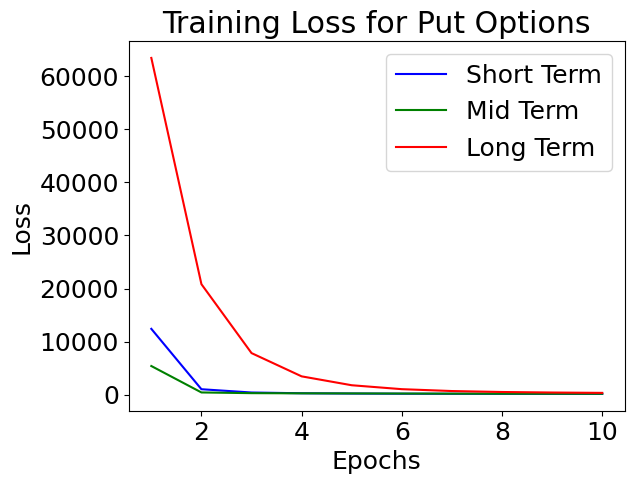

In [ ]:
# Extract the loss values from the training history
loss_put_short = history_put_rnn_short.history['loss']
loss_put_mid = history_put_rnn_mid.history['loss']
loss_put_long = history_put_rnn_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_put_short) + 1)
plt.plot(epochs, loss_put_short, 'b-', label='Short Term')
plt.plot(epochs, loss_put_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_put_long, 'r-', label='Long Term')
plt.title('Training Loss for Put Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Increasing the complexity of the RNN model by adding multiple layers

1.   The input data goes into the first SimpleRNN layer with 50 units (or cells), which processes the input and returns sequences. These sequences are the outputs for each time step.
2.   The sequences from the first layer are fed into the second SimpleRNN layer with 50 units. This second layer processes the sequences but does not return sequences; it only returns the final output.

1.   The output of the second SimpleRNN layer is then processed by a Dense layer with a single unit to produce the final output.

In [ ]:
# Build the RNN model for put options
rnn_model_put_short = Sequential()
rnn_model_put_short.add(SimpleRNN(50, input_shape=(X_train_put_short_reshaped.shape[1], X_train_put_short_reshaped.shape[2]), return_sequences=True))
rnn_model_put_short.add(SimpleRNN(50))
rnn_model_put_short.add(Dense(1))


# Compile the model
rnn_model_put_short.compile(loss='mse', optimizer='adam')

# Train the RNN model for put options
print("put options - Short term: ")
history_put_rnn_short = rnn_model_put_short.fit(X_train_put_short_reshaped, y_train_put_short, epochs=10, batch_size=32)


# Build the RNN model for put options
rnn_model_put_mid = Sequential()
rnn_model_put_mid.add(SimpleRNN(50, input_shape=(X_train_put_mid_reshaped.shape[1], X_train_put_mid_reshaped.shape[2]), return_sequences=True))
rnn_model_put_mid.add(SimpleRNN(50))
rnn_model_put_mid.add(Dense(1))

# Compile the model
rnn_model_put_mid.compile(loss='mse', optimizer='adam')

# Train the RNN model for put options
print("put options - Mid term: ")
history_put_rnn_mid = rnn_model_put_mid.fit(X_train_put_mid_reshaped, y_train_put_mid, epochs=10, batch_size=32)


# Build the RNN model for put options
rnn_model_put_long = Sequential()
rnn_model_put_long.add(SimpleRNN(50, input_shape=(X_train_put_long_reshaped.shape[1], X_train_put_long_reshaped.shape[2]), return_sequences=True))
rnn_model_put_long.add(SimpleRNN(50))
rnn_model_put_long.add(Dense(1))

# Compile the model
rnn_model_put_long.compile(loss='mse', optimizer='adam')

# Train the RNN model for put options
print("put options - Long term: ")
history_put_rnn_long = rnn_model_put_long.fit(X_train_put_long_reshaped, y_train_put_long, epochs=10, batch_size=32)

put options - Short term: 
Epoch 1/10
59684/59684 [==============================] - 142s 2ms/step - loss: 6136.1841
Epoch 2/10
59684/59684 [==============================] - 152s 3ms/step - loss: 266.6469
Epoch 3/10
59684/59684 [==============================] - 144s 2ms/step - loss: 101.0668
Epoch 4/10
59684/59684 [==============================] - 146s 2ms/step - loss: 77.1331
Epoch 5/10
59684/59684 [==============================] - 154s 3ms/step - loss: 67.0482
Epoch 6/10
59684/59684 [==============================] - 152s 3ms/step - loss: 61.7216
Epoch 7/10
59684/59684 [==============================] - 151s 3ms/step - loss: 58.5427
Epoch 8/10
59684/59684 [==============================] - 157s 3ms/step - loss: 56.4701
Epoch 9/10
59684/59684 [==============================] - 161s 3ms/step - loss: 54.9608
Epoch 10/10
59684/59684 [==============================] - 152s 3ms/step - loss: 53.5743
put options - Mid term: 
Epoch 1/10
130610/130610 [==============================] - 311

In [ ]:
# Predict option prices using the trained RNN models
predicted_put_prices_rnn_short = rnn_model_put_short.predict(X_test_put_short_reshaped)
predicted_put_prices_rnn_mid = rnn_model_put_mid.predict(X_test_put_mid_reshaped)
predicted_put_prices_rnn_long = rnn_model_put_long.predict(X_test_put_long_reshaped)

# Print or use the predicted option prices as needed
print("Predicted Put Option Prices - Short Term:")
print(predicted_put_prices_rnn_short)
print("Predicted Put Option Prices - Mid Term:")
print(predicted_put_prices_rnn_mid)
print("Predicted Put Option Prices - Long Term:")
print(predicted_put_prices_rnn_long)

2978/2978 [==============================] - 5s 2ms/step
Predicted Put Option Prices - Short Term:
[[119.47283   ]
 [  1.5874329 ]
 [  0.29050446]
 ...
 [154.14914   ]
 [ 86.87952   ]
 [ 86.679184  ]]
Predicted Put Option Prices - Mid Term:
[[  0.81066895]
 [  1.256073  ]
 [ 33.269283  ]
 ...
 [  0.82359314]
 [ 19.054092  ]
 [128.24191   ]]
Predicted Put Option Prices - Long Term:
[[ 35.03653  ]
 [  4.9642982]
 [320.41687  ]
 ...
 [ 97.222404 ]
 [663.1408   ]
 [263.5264   ]]


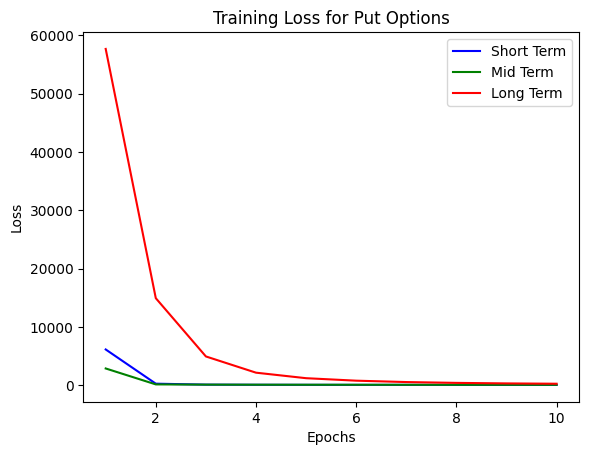

In [ ]:
# Extract the loss values from the training history
loss_put_short = history_put_rnn_short.history['loss']
loss_put_mid = history_put_rnn_mid.history['loss']
loss_put_long = history_put_rnn_long.history['loss']

# Create a line chart to visualize the loss values
epochs = range(1, len(loss_put_short) + 1)
plt.plot(epochs, loss_put_short, 'b-', label='Short Term')
plt.plot(epochs, loss_put_mid, 'g-', label='Mid Term')
plt.plot(epochs, loss_put_long, 'r-', label='Long Term')
plt.title('Training Loss for Put Options')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Evaluation
use a combination of error-based metrics and overall performance metrics to evaluate the models for option pricing.

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate predictions for call and put options using LSTM models
lstm_predicted_call_prices_short = lstm_model_call_short.predict(X_test_call_short_reshaped)
lstm_predicted_call_prices_mid = lstm_model_call_mid.predict(X_test_call_mid_reshaped)
lstm_predicted_call_prices_long = lstm_model_call_long.predict(X_test_call_long_reshaped)
lstm_predicted_put_prices_short = lstm_model_put_short.predict(X_test_put_short_reshaped)
lstm_predicted_put_prices_mid = lstm_model_put_mid.predict(X_test_put_mid_reshaped)
lstm_predicted_put_prices_long = lstm_model_put_long.predict(X_test_put_long_reshaped)

# Generate predictions for call and put options using RNN models
rnn_predicted_call_prices_short = rnn_model_call_short.predict(X_test_call_short_reshaped)
rnn_predicted_call_prices_mid = rnn_model_call_mid.predict(X_test_call_mid_reshaped)
rnn_predicted_call_prices_long = rnn_model_call_long.predict(X_test_call_long_reshaped)
rnn_predicted_put_prices_short = rnn_model_put_short.predict(X_test_put_short_reshaped)
rnn_predicted_put_prices_mid = rnn_model_put_mid.predict(X_test_put_mid_reshaped)
rnn_predicted_put_prices_long = rnn_model_put_long.predict(X_test_put_long_reshaped)

2978/2978 [==============================] - 5s 2ms/step


In [ ]:
# Calculate Mean Squared Error (MSE) for call options
lstm_call_mse_short = mean_squared_error(y_test_call_short, lstm_predicted_call_prices_short)
lstm_call_mse_mid = mean_squared_error(y_test_call_mid, lstm_predicted_call_prices_mid)
lstm_call_mse_long = mean_squared_error(y_test_call_long, lstm_predicted_call_prices_long)
rnn_call_mse_short = mean_squared_error(y_test_call_short, rnn_predicted_call_prices_short)
rnn_call_mse_mid = mean_squared_error(y_test_call_mid, rnn_predicted_call_prices_mid)
rnn_call_mse_long = mean_squared_error(y_test_call_long, rnn_predicted_call_prices_long)

# Calculate Mean Squared Error (MSE) for put options
lstm_put_mse_short = mean_squared_error(y_test_put_short, lstm_predicted_put_prices_short)
lstm_put_mse_mid = mean_squared_error(y_test_put_mid, lstm_predicted_put_prices_mid)
lstm_put_mse_long = mean_squared_error(y_test_put_long, lstm_predicted_put_prices_long)
rnn_put_mse_short = mean_squared_error(y_test_put_short, rnn_predicted_put_prices_short)
rnn_put_mse_mid = mean_squared_error(y_test_put_mid, rnn_predicted_put_prices_mid)
rnn_put_mse_long = mean_squared_error(y_test_put_long, rnn_predicted_put_prices_long)

In [ ]:
# Define the models and terms
models = ['BS', 'RNN', 'LSTM']
terms = ['Short', 'Mid', 'Long']

# Define the MSE values for call and put options using different models and terms
call_mses = [
    [mse_call_bs_short, rnn_call_mse_short, lstm_call_mse_short],
    [mse_call_bs_mid, rnn_call_mse_mid, lstm_call_mse_mid],
    [mse_call_bs_long, rnn_call_mse_long, lstm_call_mse_long]
]
put_mses = [
    [mse_put_bs_short, rnn_put_mse_short, lstm_put_mse_short],
    [mse_put_bs_mid, rnn_put_mse_mid, lstm_put_mse_mid],
    [mse_put_bs_long, rnn_put_mse_long, lstm_put_mse_long]
]

# Print MSE values for call options
print("Mean Squared Error (MSE) for Call Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {call_mses[i][j]}")
    print()

# Print MSE values for put options
print("Mean Squared Error (MSE) for Put Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {put_mses[i][j]}")
    print()



Mean Squared Error (MSE) for Call Options:
Short Term:
    BS: 161.2149820580643
    RNN: 60.29994407999818
    LSTM: 115.3235466109683

Mid Term:
    BS: 2349.846226638409
    RNN: 96.29899222456652
    LSTM: 135.4304266680366

Long Term:
    BS: 80501.91128930525
    RNN: 1783.3948283194666
    LSTM: 32539.359611524964

Mean Squared Error (MSE) for Put Options:
Short Term:
    BS: 165.82283621727777
    RNN: 47.787728820169065
    LSTM: 67.15965017100152

Mid Term:
    BS: 3333.2331374392093
    RNN: 64.03121586243928
    LSTM: 106.37549119628513

Long Term:
    BS: 101716.19049861717
    RNN: 272.7996520076319
    LSTM: 411.2197326905977



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE and R2 for call options
bs_call_rmse_short = np.sqrt(mean_squared_error(y_test_call_short, predicted_call_prices_bs_short))
bs_call_r2_short = r2_score(y_test_call_short, predicted_call_prices_bs_short)
bs_call_rmse_mid = np.sqrt(mean_squared_error(y_test_call_mid, predicted_call_prices_bs_mid))
bs_call_r2_mid = r2_score(y_test_call_mid, predicted_call_prices_bs_mid)
bs_call_rmse_long = np.sqrt(mean_squared_error(y_test_call_long, predicted_call_prices_bs_long))
bs_call_r2_long = r2_score(y_test_call_long, predicted_call_prices_bs_long)

lstm_call_rmse_short = np.sqrt(mean_squared_error(y_test_call_short, lstm_predicted_call_prices_short))
lstm_call_r2_short = r2_score(y_test_call_short, lstm_predicted_call_prices_short)
lstm_call_rmse_mid = np.sqrt(mean_squared_error(y_test_call_mid, lstm_predicted_call_prices_mid))
lstm_call_r2_mid = r2_score(y_test_call_mid, lstm_predicted_call_prices_mid)
lstm_call_rmse_long = np.sqrt(mean_squared_error(y_test_call_long, lstm_predicted_call_prices_long))
lstm_call_r2_long = r2_score(y_test_call_long, lstm_predicted_call_prices_long)

rnn_call_rmse_short = np.sqrt(mean_squared_error(y_test_call_short, rnn_predicted_call_prices_short))
rnn_call_r2_short = r2_score(y_test_call_short, rnn_predicted_call_prices_short)
rnn_call_rmse_mid = np.sqrt(mean_squared_error(y_test_call_mid, rnn_predicted_call_prices_mid))
rnn_call_r2_mid = r2_score(y_test_call_mid, rnn_predicted_call_prices_mid)
rnn_call_rmse_long = np.sqrt(mean_squared_error(y_test_call_long, rnn_predicted_call_prices_long))
rnn_call_r2_long = r2_score(y_test_call_long, rnn_predicted_call_prices_long)

# Calculate RMSE and R2 for put options
bs_put_rmse_short = np.sqrt(mean_squared_error(y_test_put_short, predicted_put_prices_bs_short))
bs_put_r2_short = r2_score(y_test_put_short, predicted_put_prices_bs_short)
bs_put_rmse_mid = np.sqrt(mean_squared_error(y_test_put_mid, predicted_put_prices_bs_mid))
bs_put_r2_mid = r2_score(y_test_put_mid, predicted_put_prices_bs_mid)
bs_put_rmse_long = np.sqrt(mean_squared_error(y_test_put_long, predicted_put_prices_bs_long))
bs_put_r2_long = r2_score(y_test_put_long, predicted_put_prices_bs_long)

lstm_put_rmse_short = np.sqrt(mean_squared_error(y_test_put_short, lstm_predicted_put_prices_short))
lstm_put_r2_short = r2_score(y_test_put_short, lstm_predicted_put_prices_short)
lstm_put_rmse_mid = np.sqrt(mean_squared_error(y_test_put_mid, lstm_predicted_put_prices_mid))
lstm_put_r2_mid = r2_score(y_test_put_mid, lstm_predicted_put_prices_mid)
lstm_put_rmse_long = np.sqrt(mean_squared_error(y_test_put_long, lstm_predicted_put_prices_long))
lstm_put_r2_long = r2_score(y_test_put_long, lstm_predicted_put_prices_long)

rnn_put_rmse_short = np.sqrt(mean_squared_error(y_test_put_short, rnn_predicted_put_prices_short))
rnn_put_r2_short = r2_score(y_test_put_short, rnn_predicted_put_prices_short)
rnn_put_rmse_mid = np.sqrt(mean_squared_error(y_test_put_mid, rnn_predicted_put_prices_mid))
rnn_put_r2_mid = r2_score(y_test_put_mid, rnn_predicted_put_prices_mid)
rnn_put_rmse_long = np.sqrt(mean_squared_error(y_test_put_long, rnn_predicted_put_prices_long))
rnn_put_r2_long = r2_score(y_test_put_long, rnn_predicted_put_prices_long)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Define the models and terms
models = ['BS', 'RNN', 'LSTM']
terms = ['Short', 'Mid', 'Long']

# Define the RMSE and R2 values for call and put options using different models and terms
call_rmse = [
    [bs_call_rmse_short, rnn_call_rmse_short, lstm_call_rmse_short],
    [bs_call_rmse_mid, rnn_call_rmse_mid, lstm_call_rmse_mid],
    [bs_call_rmse_long, rnn_call_rmse_long, lstm_call_rmse_long]
]
put_rmse = [
    [bs_put_rmse_short, rnn_put_rmse_short, lstm_put_rmse_short],
    [bs_put_rmse_mid, rnn_put_rmse_mid, lstm_put_rmse_mid],
    [bs_put_rmse_long, rnn_put_rmse_long, lstm_put_rmse_long]
]

call_r2 = [
    [bs_call_r2_short, rnn_call_r2_short, lstm_call_r2_short],
    [bs_call_r2_mid, rnn_call_r2_mid, lstm_call_r2_mid],
    [bs_call_r2_long, rnn_call_r2_long, lstm_call_r2_long]
]
put_r2 = [
    [bs_put_r2_short, rnn_put_r2_short, lstm_put_r2_short],
    [bs_put_r2_mid, rnn_put_r2_mid, lstm_put_r2_mid],
    [bs_put_r2_long, rnn_put_r2_long, lstm_put_r2_long]
]

# Print RMSE values for call options
print("Root Mean Squared Error (RMSE) for Call Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {call_rmse[i][j]}")
    print()

# Print R2 values for call options
print("R2 Values for Call Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {call_r2[i][j]}")
    print()

# Print RMSE values for put options
print("Root Mean Squared Error (RMSE) for Put Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {put_rmse[i][j]}")
    print()

# Print R2 values for put options
print("R2 Values for Put Options:")
for i, term in enumerate(terms):
    print(f"{term} Term:")
    for j, model in enumerate(models):
        print(f"    {model}: {put_r2[i][j]}")
    print()


Root Mean Squared Error (RMSE) for Call Options:
Short Term:
    BS: 12.697046194216366
    RNN: 7.7653038626957915
    LSTM: 10.7388801376572

Mid Term:
    BS: 48.47521249709391
    RNN: 9.813204992486732
    LSTM: 11.637457912621493

Long Term:
    BS: 283.7285873670562
    RNN: 42.23025962884276
    LSTM: 180.38669466322887

R2 Values for Call Options:
Short Term:
    BS: 0.9988038049873854
    RNN: 0.9995525819533109
    LSTM: 0.999144313701295

Mid Term:
    BS: 0.992309064355241
    RNN: 0.9996848179495925
    LSTM: 0.9995567426140322

Long Term:
    BS: 0.8486988709980468
    RNN: 0.9966481584516512
    LSTM: 0.9388431682257669

Root Mean Squared Error (RMSE) for Put Options:
Short Term:
    BS: 12.877221603175032
    RNN: 6.912866903114009
    LSTM: 8.195099155654038

Mid Term:
    BS: 57.73415919054515
    RNN: 8.00195075356249
    LSTM: 10.313849484857005

Long Term:
    BS: 318.92975793835416
    RNN: 16.516647723059055
    LSTM: 20.27855351573671

R2 Values for Put Options

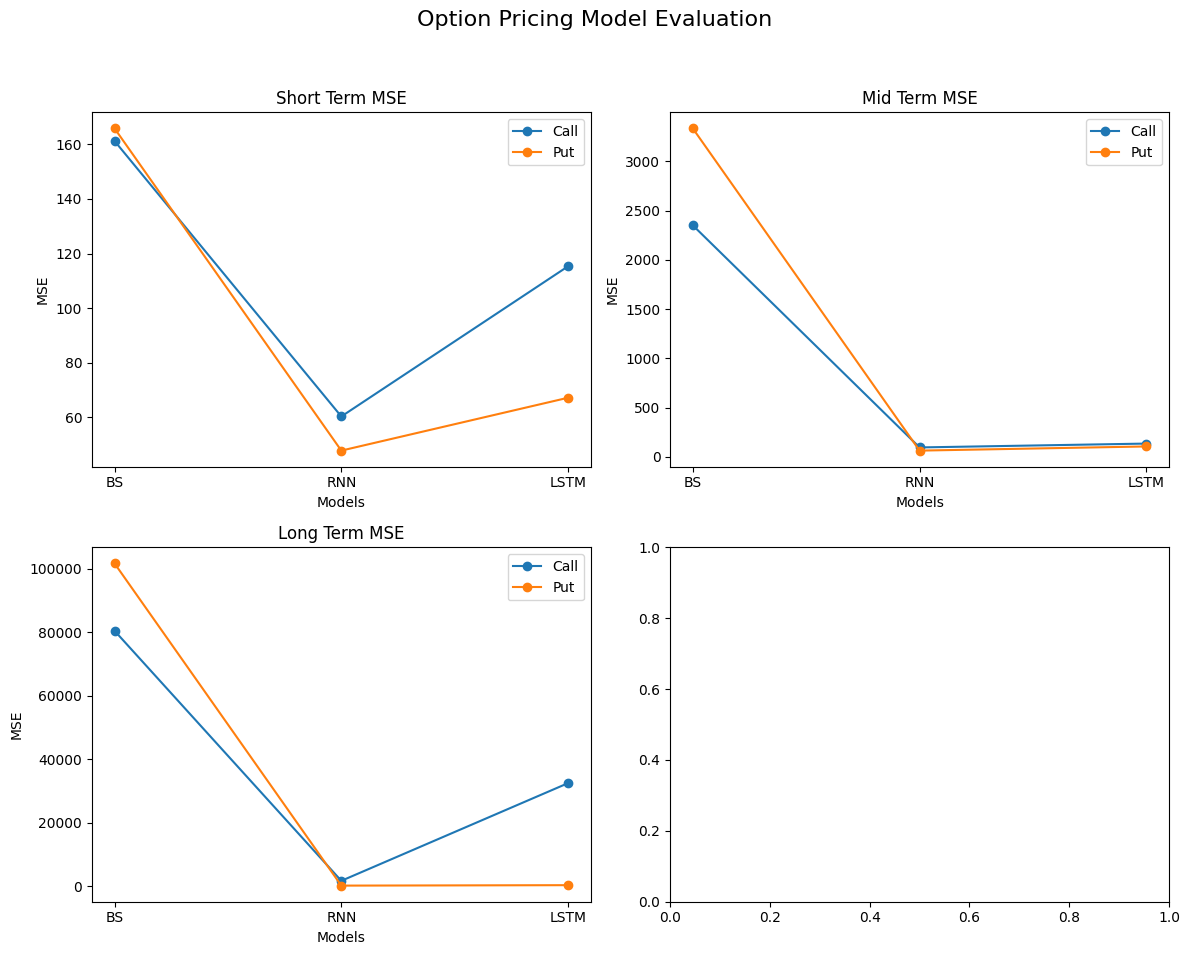

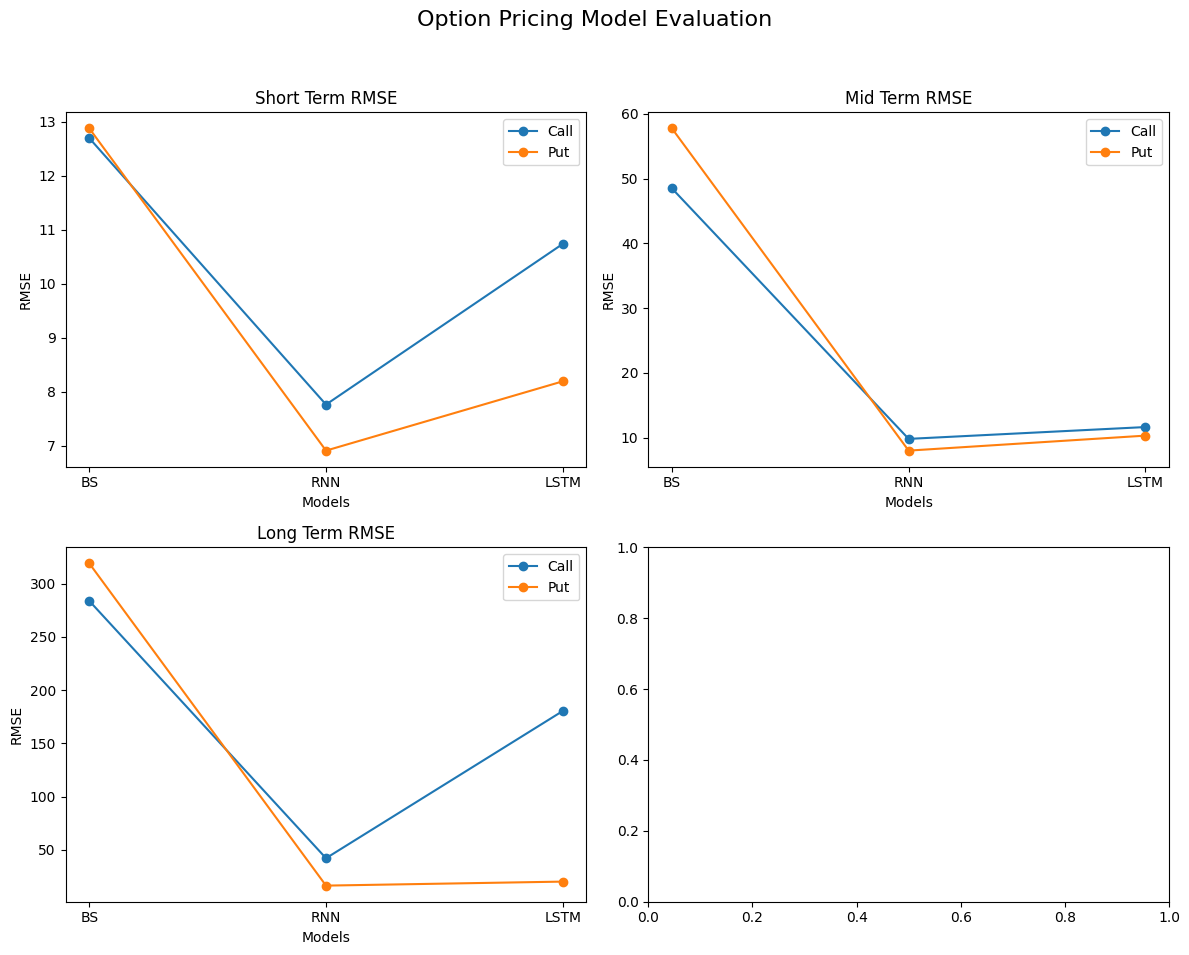

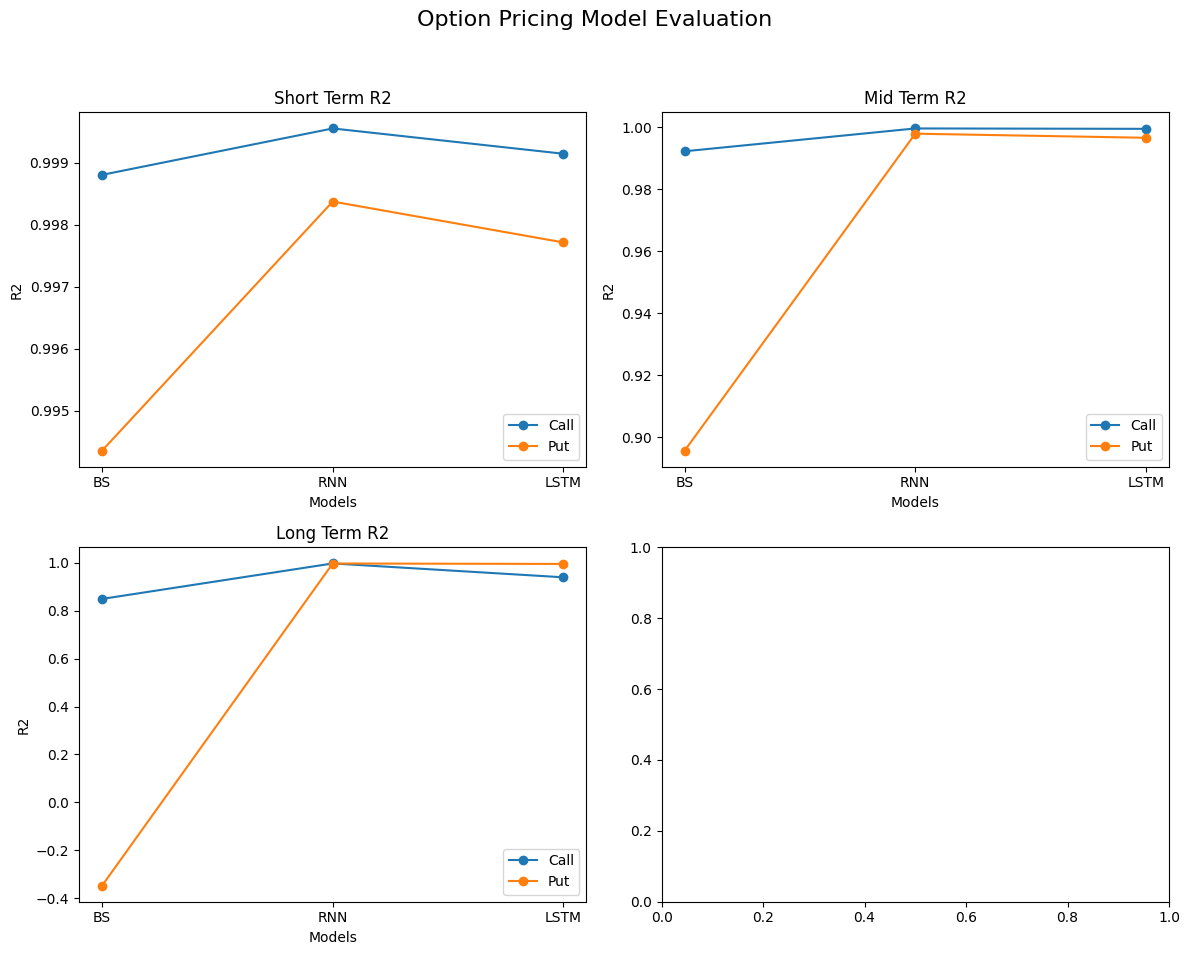

In [ ]:
# mse plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Option Pricing Model Evaluation', fontsize=16)

for i, term in enumerate(terms):
    ax = axes[i // 2, i % 2]
    ax.plot(models, call_mses[i], marker='o', label='Call')
    ax.plot(models, put_mses[i], marker='o', label='Put')
    ax.set_title(f'{term} Term MSE')
    ax.set_xlabel('Models')
    ax.set_ylabel('MSE')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show mse plots
plt.show()

# Create subplots for RMSE and R2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Option Pricing Model Evaluation', fontsize=16)

# RMSE plots
for i, term in enumerate(terms):
    ax = axes[i // 2, i % 2]
    ax.plot(models, call_rmse[i], marker='o', label='Call')
    ax.plot(models, put_rmse[i], marker='o', label='Put')
    ax.set_title(f'{term} Term RMSE')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show RMSE plots
plt.show()

# R2 plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Option Pricing Model Evaluation', fontsize=16)

for i, term in enumerate(terms):
    ax = axes[i // 2, i % 2]
    ax.plot(models, call_r2[i], marker='o', label='Call')
    ax.plot(models, put_r2[i], marker='o', label='Put')
    ax.set_title(f'{term} Term R2')
    ax.set_xlabel('Models')
    ax.set_ylabel('R2')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show R2 plots
plt.show()

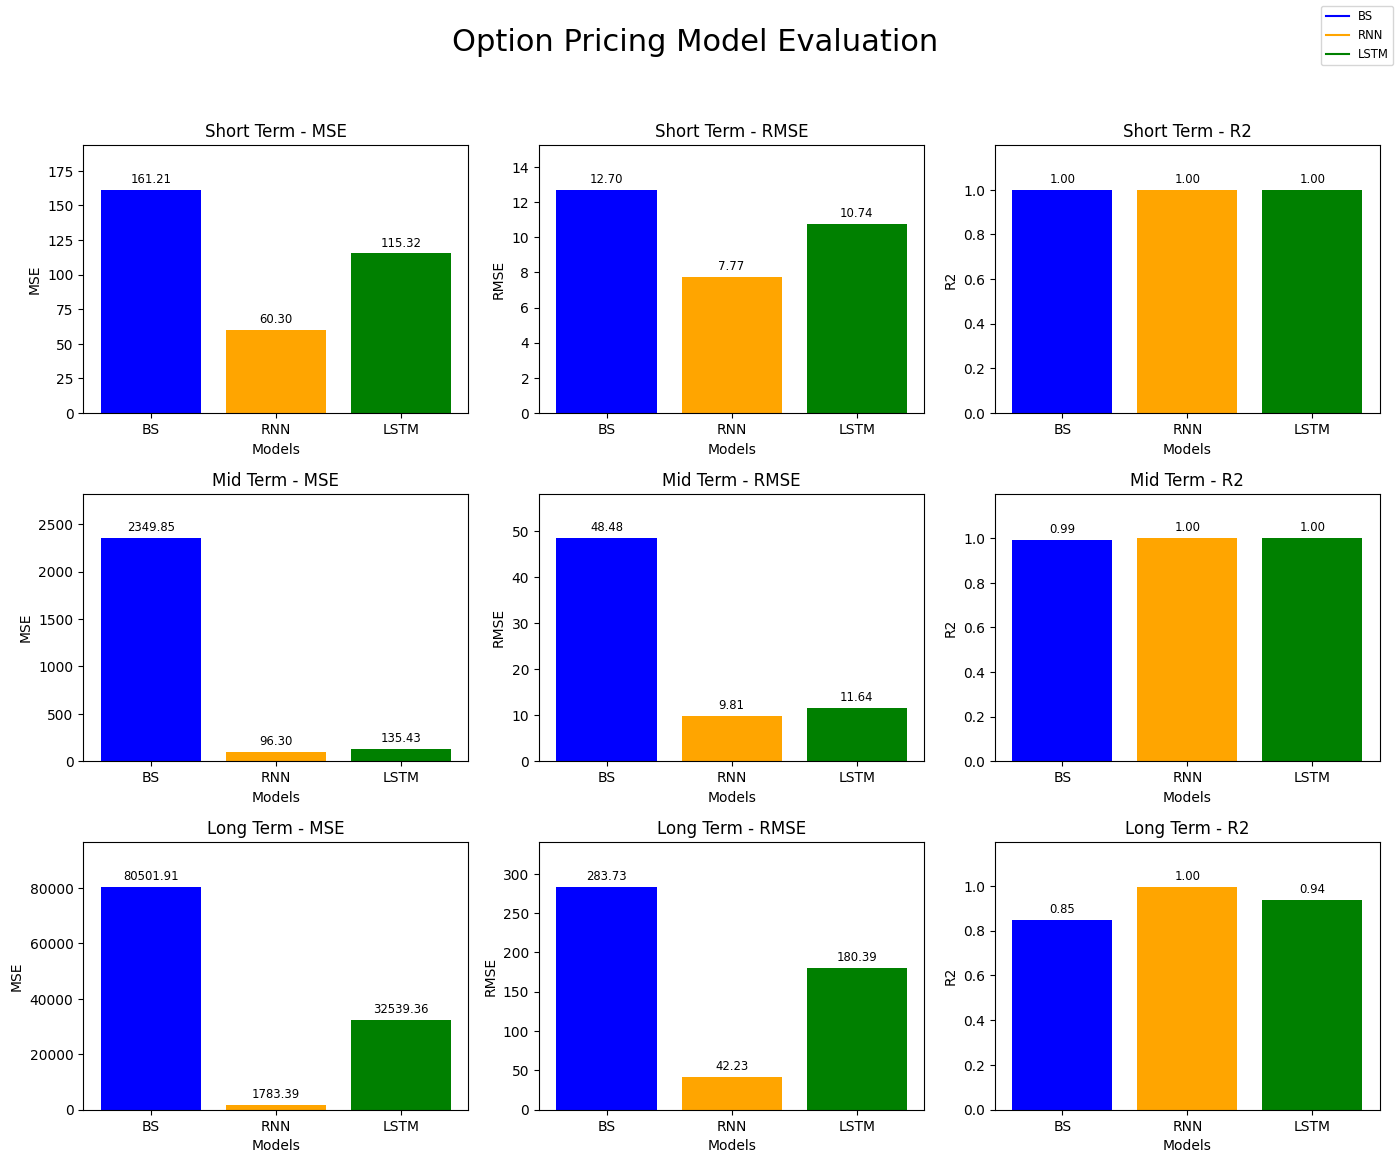

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create subplots for MSE, RMSE, and R2 comparisons
fig, axes = plt.subplots(nrows=len(terms), ncols=3, figsize=(14, 12))
fig.suptitle('Option Pricing Model Evaluation', fontsize=22)

metrics = ['MSE', 'RMSE', 'R2']
metric_values = [call_mses, call_rmse, call_r2]

model_colors = ['blue', 'orange', 'green']
model_labels = ['BS', 'RNN', 'LSTM']

for i, term in enumerate(terms):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        values = metric_values[j][i]

        bars = ax.bar(models, values, color=model_colors)
        ax.set_title(f'{term} Term - {metric}')
        ax.set_xlabel('Models')
        ax.set_ylabel(metric)
        ax.set_ylim([0, np.max(values) * 1.2])
        ax.set_xticks(models)

        # Annotate each bar with the corresponding value
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize='small')

# Create a custom legend using Line2D artists
legend_elements = [Line2D([0], [0], color=color, label=label) for color, label in zip(model_colors, model_labels)]
fig.legend(handles=legend_elements, loc='upper right', fontsize='small')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plots
plt.show()

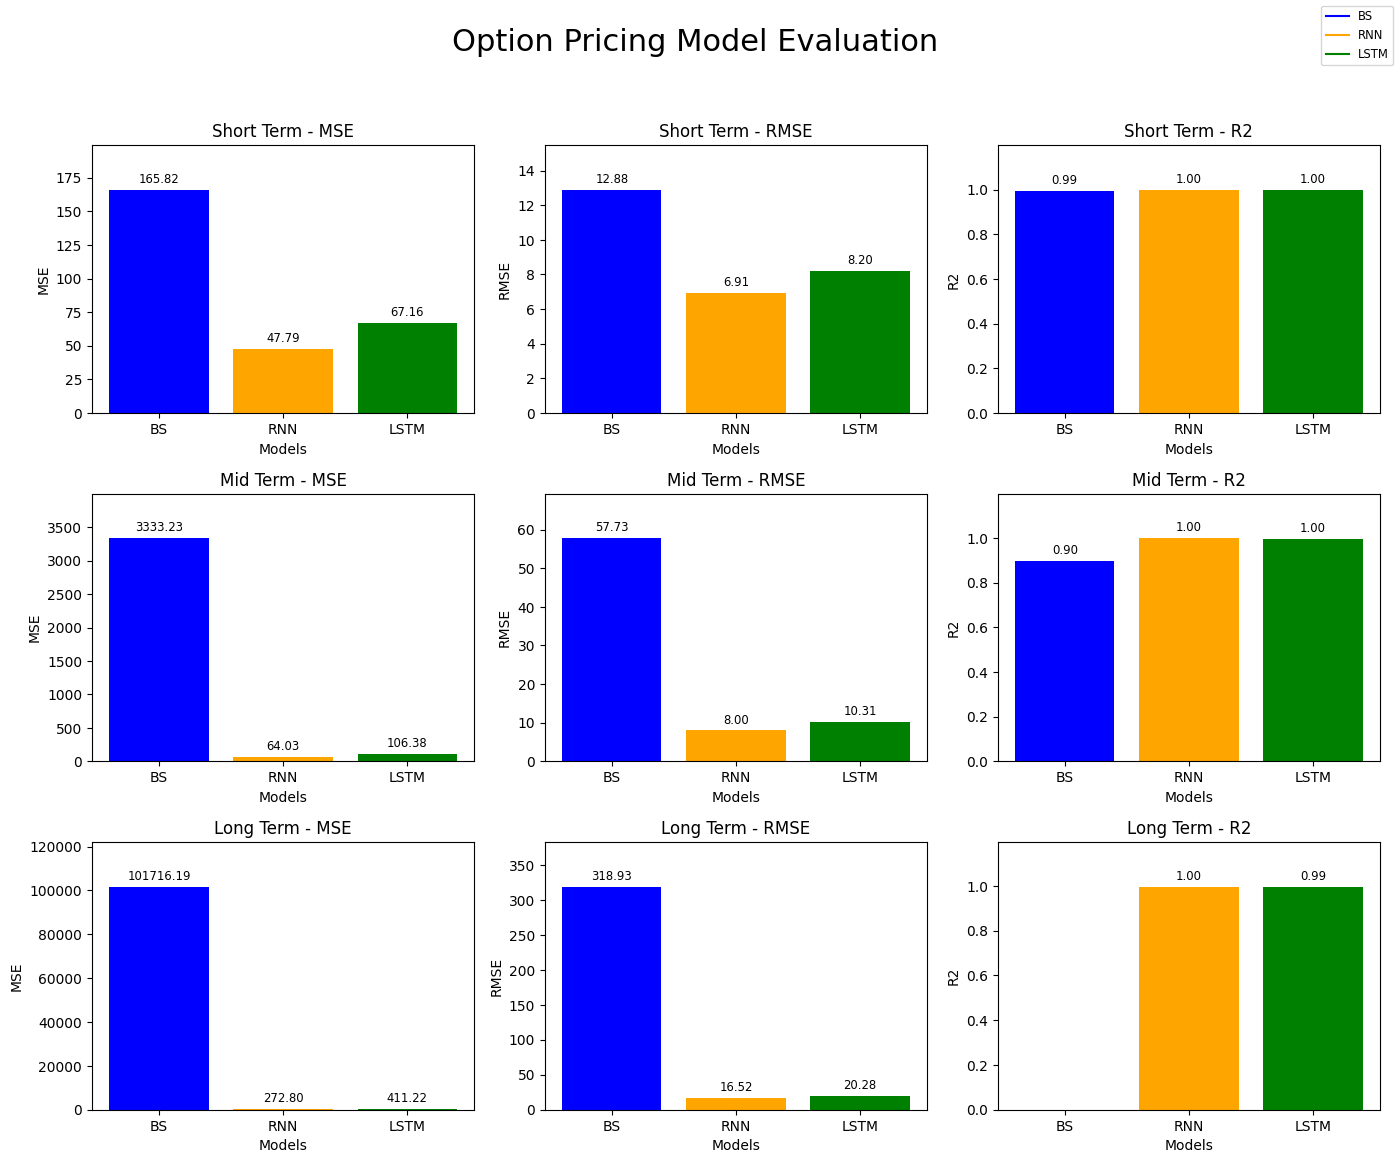

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create subplots for MSE, RMSE, and R2 comparisons
fig, axes = plt.subplots(nrows=len(terms), ncols=3, figsize=(14, 12))
fig.suptitle('Option Pricing Model Evaluation', fontsize=22)

metrics = ['MSE', 'RMSE', 'R2']
metric_values = [put_mses, put_rmse, put_r2]

model_colors = ['blue', 'orange', 'green']
model_labels = ['BS', 'RNN', 'LSTM']

for i, term in enumerate(terms):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        values = metric_values[j][i]

        bars = ax.bar(models, values, color=model_colors)
        ax.set_title(f'{term} Term - {metric}')
        ax.set_xlabel('Models')
        ax.set_ylabel(metric)
        ax.set_ylim([0, np.max(values) * 1.2])
        ax.set_xticks(models)

        # Annotate each bar with the corresponding value
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize='small')

# Create a custom legend using Line2D artists
legend_elements = [Line2D([0], [0], color=color, label=label) for color, label in zip(model_colors, model_labels)]
fig.legend(handles=legend_elements, loc='upper right', fontsize='small')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plots
plt.show()